# GAN para generar imágenes de prendas y accesorios

En este cuaderno implementaremos una GAN para crear imágenes de prendas de vestir y accesorios.

Para el entrenamiento de la GAN se hará uso del dataset *Fashion MNIST*.

## Importa librerías

In [5]:
# Importa las librerías necesarias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import glob
from datetime import datetime
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import fashion_mnist

## Recogemos el dataset

In [3]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

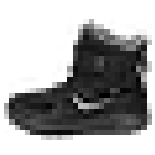

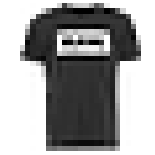

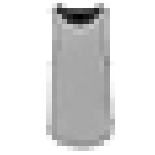

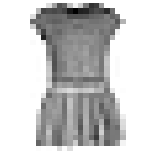

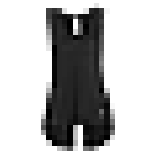

In [4]:
# Carga y muestra algunas imágenes del dataset
for img in x_train[:5]:
  plt.figure(dpi=40)
  plt.imshow(img, cmap="binary")
  plt.axis('off')
plt.show()

In [5]:
# Verifica que todas las dimensiones sean la misma (28, 28)
set([x.shape for x in x_train])

{(28, 28)}

In [6]:
# Unimos las imágenes de entrenamiento y de prueba
or_images = np.concatenate([x_train, x_test])
or_images.shape

(70000, 28, 28)

## Procesa las imágenes

In [7]:
# Comprueba si están normalizadas
or_images.min(), or_images.max()

(np.uint8(0), np.uint8(255))

In [8]:
# Carga y procesa el dataset CelebA

# Parámetros del dataset y del modelo
BATCH_SIZE = 256
NUMBER_OF_IMAGES = 70000

# Lista para almacenar las imágenes procesadas
images = []

# Procesa las imágenes del dataset
for i in range(NUMBER_OF_IMAGES):
  img = or_images[i] / 255
  images.append(img)

# Convierte las imágenes a un array de numpy y prepara el dataset de TensorFlow
dataset = np.array(images)
dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(NUMBER_OF_IMAGES).batch(BATCH_SIZE)

print(f"Dataset procesado: {NUMBER_OF_IMAGES} imágenes cargadas y preparadas.")

Dataset procesado: 70000 imágenes cargadas y preparadas.


2025-02-11 17:03:11.378541: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
# Verifica la estructura del dataset
for batch in dataset.take(1):  # Toma un lote
  print("Dimensiones del lote:", batch.shape)
  print("Rango: de", batch.numpy().min(), "a", batch.numpy().max())

Dimensiones del lote: (256, 28, 28)
Rango: de 0.0 a 1.0


2025-02-11 17:03:11.753880: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Generador


In [10]:
# Define el generador
LATENT_DIM = 200

generator = keras.Sequential([
    # Capa densa inicial
    layers.Dense(3 * 3 * 256, input_shape=(LATENT_DIM,)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Redimensión a las dimensiones iniciales
    layers.Reshape((3, 3, 256)),

    # Primera capa de convolución
    layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Segunda capa de convolución
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Tercera capa de convolución
    layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Capa final de ajuste a 28x28
    layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), activation='tanh')

])

generator.summary()

/usr/local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2304)           │       463,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2304)           │         9,216 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 6, 6, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 12, 12, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 24, 24, 32)     │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 1)      │           801 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,549,217 (5.91 MB)

 Trainable params: 1,544,161 (5.89 MB)

 Non-trainable params: 5,056 (19.75 KB)

Dimensiones de la imagen generada: (1, 28, 28, 1)
Rango de valores de la imagen generada: de -0.08180227 a 0.058888018


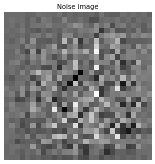

In [11]:
# Comprueba que el generador está funcionando correctamente

# Genera un vector latente aleatorio (ruido)
noise = tf.random.normal([1, LATENT_DIM])

# Genera una imagen utilizando el generador
generated_image = generator(noise, training=False)

# Muestra las dimensiones de la iamgen generada
print("Dimensiones de la imagen generada:", generated_image.shape)

# Verifica el rango de valores de la imagen generada
print("Rango de valores de la imagen generada: de", generated_image.numpy().min(), "a", generated_image.numpy().max())

# Muestra la imagen generada
plt.figure(dpi=40)
plt.imshow((generated_image[0]+1) / 2, cmap="binary")  # Reescala la imagen al rango [0, 1] para visualizarla
plt.axis('off')
plt.title("Noise image")
plt.show()

In [12]:
# Define el discriminador
discriminator = keras.Sequential([
    layers.Input((28, 28, 1)),
    # Primera capa convolucional
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', ),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    # Segunda capa convolucional
    layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    # Aplana la salida
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')  # Decide si la imagen es real o generada
])

# Muestra el resumen del modelo
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Prueba el discriminador con una imagen creada por el generador
noise = tf.random.normal([1, LATENT_DIM])
generated_image = generator(noise, training=False)

# Pasa la imagen por el discriminador
decision = discriminator(generated_image)
print("Decisión del discriminador (valor cercano a 0 = falsa, 1 = real):", decision)

Decisión del discriminador (valor cercano a 0 = falsa, 1 = real): tf.Tensor([[0.5009919]], shape=(1, 1), dtype=float32)


In [14]:
# Inspecciona un lote del dataset
for batch in dataset.take(1):
  print("Dimensiones del lote:", batch.shape)

Dimensiones del lote: (256, 28, 28)


2025-02-11 17:03:12.285201: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
# Parámetros del entrenmiento
EPOCHS = 1000
# LATENT_DIM = 100
# BATCH_SIZE = 32

In [23]:
# Inicializa los optimizadores y la función de pérdida
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=False)  # No se necesita logits porque la última capa era un sigmoide
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [17]:
# Crea la carpeta models si no existe
if not os.path.exists('./models'):
    os.makedirs('./models')

In [21]:
# Carga los modelos en memoria. Mover bloque donde proceda (ej. justo antes del entrenamiento)
generator = load_model("./models/generador_prendas_11-02-2025-1530_50ep_70000img.keras")
discriminator = load_model("./models/discriminador_prendas_11-02-2025-1530_50ep_70000img.keras")

Época 1 de 1000
Pérdida del discriminador: 0.7095522284507751, Pérdida del generador: 2.350403308868408
Pérdida del discriminador: 0.853513777256012, Pérdida del generador: 1.618319034576416
Pérdida del discriminador: 0.7187490463256836, Pérdida del generador: 1.2956981658935547
Pérdida del discriminador: 0.8621357679367065, Pérdida del generador: 1.2366726398468018
Pérdida del discriminador: 0.8385946154594421, Pérdida del generador: 1.6276795864105225
Pérdida del discriminador: 0.7513483762741089, Pérdida del generador: 1.9048606157302856
Pérdida del discriminador: 0.8076623678207397, Pérdida del generador: 1.9474554061889648
Pérdida del discriminador: 0.7637733221054077, Pérdida del generador: 1.949092984199524
Pérdida del discriminador: 0.6676977872848511, Pérdida del generador: 1.8317534923553467
Pérdida del discriminador: 0.7687907218933105, Pérdida del generador: 1.7221132516860962
Pérdida del discriminador: 0.7505331039428711, Pérdida del generador: 1.5524146556854248
Pérdida d

2025-02-11 17:11:07.375311: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


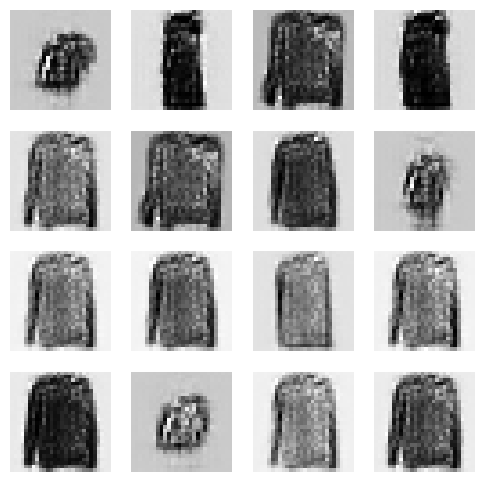

Época 3 de 1000
Pérdida del discriminador: 0.7678784132003784, Pérdida del generador: 1.7475910186767578
Pérdida del discriminador: 0.7378913164138794, Pérdida del generador: 1.88979172706604
Pérdida del discriminador: 0.7171204090118408, Pérdida del generador: 1.9587321281433105
Pérdida del discriminador: 0.8223647475242615, Pérdida del generador: 1.8423793315887451
Pérdida del discriminador: 0.6447633504867554, Pérdida del generador: 1.7254514694213867
Pérdida del discriminador: 0.7483519315719604, Pérdida del generador: 1.5553092956542969
Pérdida del discriminador: 0.7269942164421082, Pérdida del generador: 1.6963354349136353
Pérdida del discriminador: 0.7792479395866394, Pérdida del generador: 1.798922061920166
Pérdida del discriminador: 0.6454751491546631, Pérdida del generador: 1.9097785949707031
Pérdida del discriminador: 0.7055094838142395, Pérdida del generador: 1.9146764278411865
Pérdida del discriminador: 0.781925618648529, Pérdida del generador: 1.7745423316955566
Pérdida d

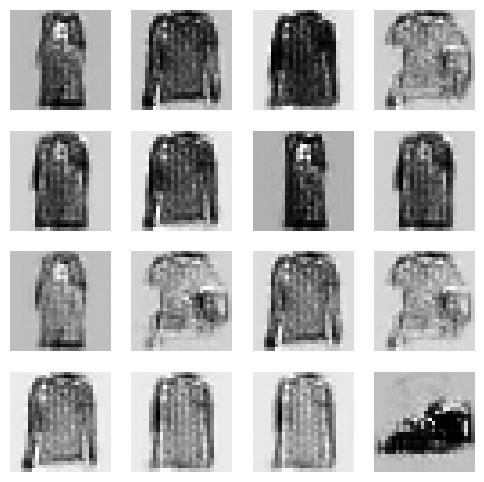

Época 5 de 1000
Pérdida del discriminador: 0.8933205604553223, Pérdida del generador: 1.618322491645813
Pérdida del discriminador: 0.8503291606903076, Pérdida del generador: 1.6791884899139404
Pérdida del discriminador: 0.818678617477417, Pérdida del generador: 1.7805507183074951
Pérdida del discriminador: 0.8948575258255005, Pérdida del generador: 1.8444561958312988
Pérdida del discriminador: 0.8849384784698486, Pérdida del generador: 1.813647985458374
Pérdida del discriminador: 0.9176309704780579, Pérdida del generador: 1.5558762550354004
Pérdida del discriminador: 0.8188930749893188, Pérdida del generador: 1.5536556243896484
Pérdida del discriminador: 0.8243298530578613, Pérdida del generador: 1.6017276048660278
Pérdida del discriminador: 0.921821653842926, Pérdida del generador: 1.7697396278381348
Pérdida del discriminador: 0.927515983581543, Pérdida del generador: 1.8306488990783691
Pérdida del discriminador: 0.8627040982246399, Pérdida del generador: 1.8306024074554443
Pérdida de

2025-02-11 17:21:08.949514: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


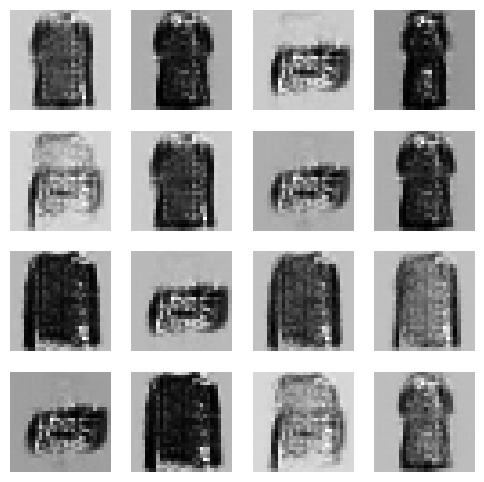

Época 7 de 1000
Pérdida del discriminador: 0.7120149731636047, Pérdida del generador: 1.8654530048370361
Pérdida del discriminador: 0.907706618309021, Pérdida del generador: 1.7848201990127563
Pérdida del discriminador: 0.7385122776031494, Pérdida del generador: 1.7097790241241455
Pérdida del discriminador: 0.8196972608566284, Pérdida del generador: 1.5230858325958252
Pérdida del discriminador: 0.7655550241470337, Pérdida del generador: 1.5658941268920898
Pérdida del discriminador: 0.8400876522064209, Pérdida del generador: 1.7492008209228516
Pérdida del discriminador: 0.8610574007034302, Pérdida del generador: 1.9339985847473145
Pérdida del discriminador: 0.7839398384094238, Pérdida del generador: 1.9394603967666626
Pérdida del discriminador: 0.9126853346824646, Pérdida del generador: 1.7336394786834717
Pérdida del discriminador: 0.7183716893196106, Pérdida del generador: 1.586996078491211
Pérdida del discriminador: 0.7303367853164673, Pérdida del generador: 1.5227255821228027
Pérdida

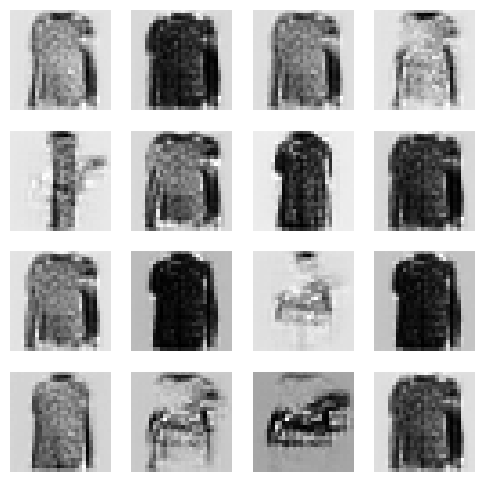

Época 9 de 1000
Pérdida del discriminador: 0.6428210735321045, Pérdida del generador: 2.059195041656494
Pérdida del discriminador: 0.7178452610969543, Pérdida del generador: 2.0881471633911133
Pérdida del discriminador: 0.6259417533874512, Pérdida del generador: 2.007624864578247
Pérdida del discriminador: 0.617711067199707, Pérdida del generador: 1.9458014965057373
Pérdida del discriminador: 0.6632013916969299, Pérdida del generador: 1.8104041814804077
Pérdida del discriminador: 0.6842281818389893, Pérdida del generador: 1.6850082874298096
Pérdida del discriminador: 0.6643261909484863, Pérdida del generador: 1.7816145420074463
Pérdida del discriminador: 0.7205525636672974, Pérdida del generador: 1.9290921688079834
Pérdida del discriminador: 0.6505124568939209, Pérdida del generador: 2.0000061988830566
Pérdida del discriminador: 0.706889808177948, Pérdida del generador: 2.0258755683898926
Pérdida del discriminador: 0.7161533832550049, Pérdida del generador: 1.9214383363723755
Pérdida d

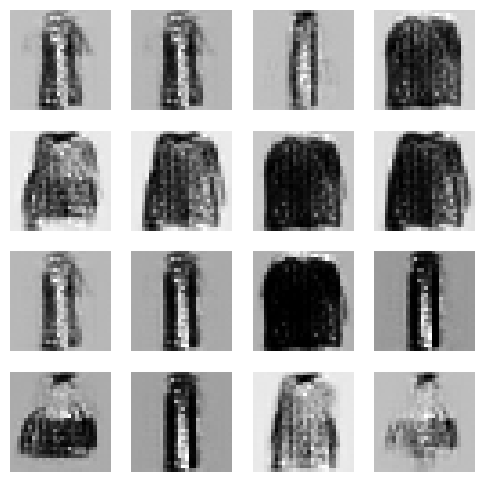

Época 11 de 1000
Pérdida del discriminador: 0.6486032009124756, Pérdida del generador: 2.2834322452545166
Pérdida del discriminador: 0.8481073975563049, Pérdida del generador: 2.2418212890625
Pérdida del discriminador: 0.6913068890571594, Pérdida del generador: 1.8941154479980469
Pérdida del discriminador: 0.7861154675483704, Pérdida del generador: 1.6766024827957153
Pérdida del discriminador: 0.8076710104942322, Pérdida del generador: 1.6456012725830078
Pérdida del discriminador: 0.7312695384025574, Pérdida del generador: 1.7928515672683716
Pérdida del discriminador: 0.6969168186187744, Pérdida del generador: 1.9420346021652222
Pérdida del discriminador: 0.8379300236701965, Pérdida del generador: 2.0709195137023926
Pérdida del discriminador: 0.8403915762901306, Pérdida del generador: 2.0567169189453125
Pérdida del discriminador: 0.826639711856842, Pérdida del generador: 1.7714931964874268
Pérdida del discriminador: 0.8173444867134094, Pérdida del generador: 1.63017737865448
Pérdida de

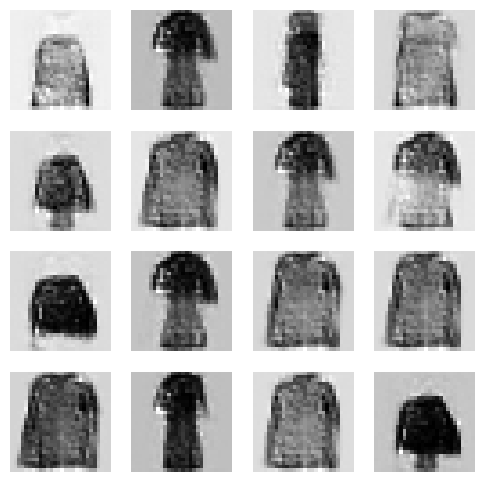

Época 13 de 1000
Pérdida del discriminador: 0.6754261255264282, Pérdida del generador: 1.653078556060791
Pérdida del discriminador: 0.6284282207489014, Pérdida del generador: 1.8854188919067383
Pérdida del discriminador: 0.8392422199249268, Pérdida del generador: 2.0246777534484863
Pérdida del discriminador: 0.7246203422546387, Pérdida del generador: 2.1083953380584717
Pérdida del discriminador: 0.7128212451934814, Pérdida del generador: 2.0051522254943848
Pérdida del discriminador: 0.7263823747634888, Pérdida del generador: 1.8435512781143188
Pérdida del discriminador: 0.6255426406860352, Pérdida del generador: 1.7399563789367676
Pérdida del discriminador: 0.7421727180480957, Pérdida del generador: 1.6926653385162354
Pérdida del discriminador: 0.7705392241477966, Pérdida del generador: 1.7323174476623535
Pérdida del discriminador: 0.60188227891922, Pérdida del generador: 1.993135929107666
Pérdida del discriminador: 0.6480315923690796, Pérdida del generador: 2.200770854949951
Pérdida d

2025-02-11 17:41:00.728768: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


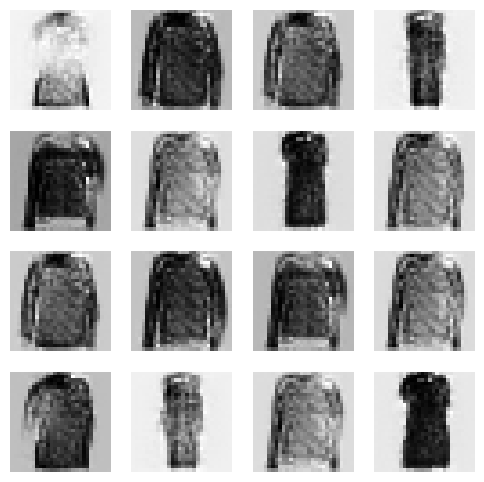

Época 15 de 1000
Pérdida del discriminador: 0.7887972593307495, Pérdida del generador: 1.681828498840332
Pérdida del discriminador: 0.691651463508606, Pérdida del generador: 1.726166009902954
Pérdida del discriminador: 0.7223093509674072, Pérdida del generador: 1.7987279891967773
Pérdida del discriminador: 0.7496597766876221, Pérdida del generador: 1.907376766204834
Pérdida del discriminador: 0.778800368309021, Pérdida del generador: 1.932591438293457
Pérdida del discriminador: 0.8254251480102539, Pérdida del generador: 1.8590738773345947
Pérdida del discriminador: 0.8131086230278015, Pérdida del generador: 1.7110605239868164
Pérdida del discriminador: 0.6847292184829712, Pérdida del generador: 1.6923775672912598
Pérdida del discriminador: 0.8113637566566467, Pérdida del generador: 1.6764161586761475
Pérdida del discriminador: 0.7996374368667603, Pérdida del generador: 1.7720892429351807
Pérdida del discriminador: 0.8447098731994629, Pérdida del generador: 1.8986979722976685
Pérdida de

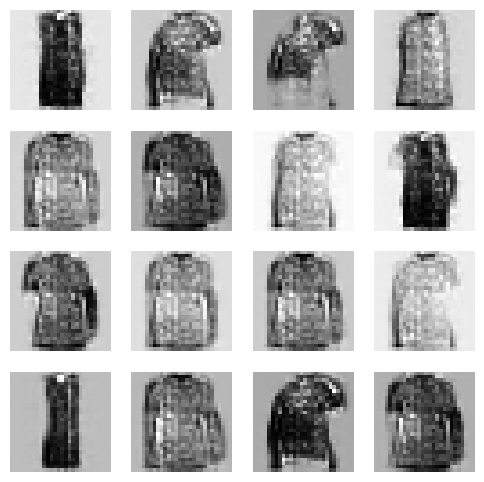

Época 17 de 1000
Pérdida del discriminador: 0.8038957118988037, Pérdida del generador: 2.0328385829925537
Pérdida del discriminador: 0.7568947076797485, Pérdida del generador: 2.0164947509765625
Pérdida del discriminador: 0.7288440465927124, Pérdida del generador: 1.979059100151062
Pérdida del discriminador: 0.7003411650657654, Pérdida del generador: 1.929241418838501
Pérdida del discriminador: 0.8816770911216736, Pérdida del generador: 1.8354151248931885
Pérdida del discriminador: 0.739916205406189, Pérdida del generador: 1.737813115119934
Pérdida del discriminador: 0.7629784345626831, Pérdida del generador: 1.7564311027526855
Pérdida del discriminador: 0.7583944797515869, Pérdida del generador: 1.7644941806793213
Pérdida del discriminador: 0.7116258144378662, Pérdida del generador: 2.0077290534973145
Pérdida del discriminador: 0.8156003355979919, Pérdida del generador: 2.0041964054107666
Pérdida del discriminador: 0.718150794506073, Pérdida del generador: 2.043095111846924
Pérdida de

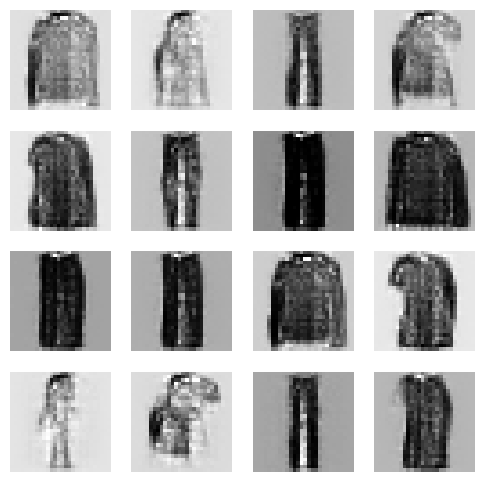

Época 19 de 1000
Pérdida del discriminador: 0.7449237108230591, Pérdida del generador: 2.110551357269287
Pérdida del discriminador: 0.7934623956680298, Pérdida del generador: 2.1390891075134277
Pérdida del discriminador: 0.7004655599594116, Pérdida del generador: 2.1467483043670654
Pérdida del discriminador: 0.7263631224632263, Pérdida del generador: 2.011861801147461
Pérdida del discriminador: 0.7028853297233582, Pérdida del generador: 1.869645118713379
Pérdida del discriminador: 0.7381559610366821, Pérdida del generador: 1.7820537090301514
Pérdida del discriminador: 0.677547812461853, Pérdida del generador: 1.7846627235412598
Pérdida del discriminador: 0.7285991907119751, Pérdida del generador: 1.8867979049682617
Pérdida del discriminador: 0.7002320289611816, Pérdida del generador: 1.986904263496399
Pérdida del discriminador: 0.6712712645530701, Pérdida del generador: 2.063498020172119
Pérdida del discriminador: 0.665841817855835, Pérdida del generador: 2.0794520378112793
Pérdida del

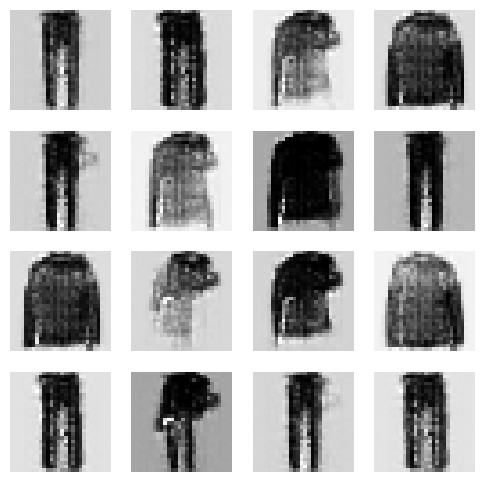

Época 21 de 1000
Pérdida del discriminador: 0.7385111451148987, Pérdida del generador: 2.1921353340148926
Pérdida del discriminador: 0.6860240697860718, Pérdida del generador: 1.8996078968048096
Pérdida del discriminador: 0.728983998298645, Pérdida del generador: 1.5855157375335693
Pérdida del discriminador: 0.6418349742889404, Pérdida del generador: 1.6068115234375
Pérdida del discriminador: 0.7974544763565063, Pérdida del generador: 1.7421364784240723
Pérdida del discriminador: 0.7406738996505737, Pérdida del generador: 2.0409984588623047
Pérdida del discriminador: 0.700308084487915, Pérdida del generador: 2.2105636596679688
Pérdida del discriminador: 0.6880219578742981, Pérdida del generador: 2.2937769889831543
Pérdida del discriminador: 0.7741472125053406, Pérdida del generador: 2.049224376678467
Pérdida del discriminador: 0.7340459823608398, Pérdida del generador: 1.7072553634643555
Pérdida del discriminador: 0.8029162883758545, Pérdida del generador: 1.5003653764724731
Pérdida de

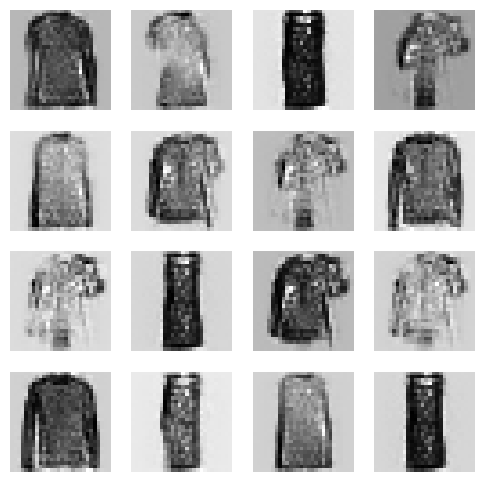

Época 23 de 1000
Pérdida del discriminador: 0.6758112907409668, Pérdida del generador: 1.9281350374221802
Pérdida del discriminador: 0.7249305248260498, Pérdida del generador: 1.9263646602630615
Pérdida del discriminador: 0.6987272500991821, Pérdida del generador: 1.931783676147461
Pérdida del discriminador: 0.7417826056480408, Pérdida del generador: 1.9417297840118408
Pérdida del discriminador: 0.675494909286499, Pérdida del generador: 1.9456405639648438
Pérdida del discriminador: 0.6766138076782227, Pérdida del generador: 2.0246996879577637
Pérdida del discriminador: 0.7048360109329224, Pérdida del generador: 2.036240339279175
Pérdida del discriminador: 0.7071367502212524, Pérdida del generador: 1.9555755853652954
Pérdida del discriminador: 0.7085134983062744, Pérdida del generador: 1.9555699825286865
Pérdida del discriminador: 0.7393786907196045, Pérdida del generador: 1.8253421783447266
Pérdida del discriminador: 0.7229998707771301, Pérdida del generador: 1.819765567779541
Pérdida 

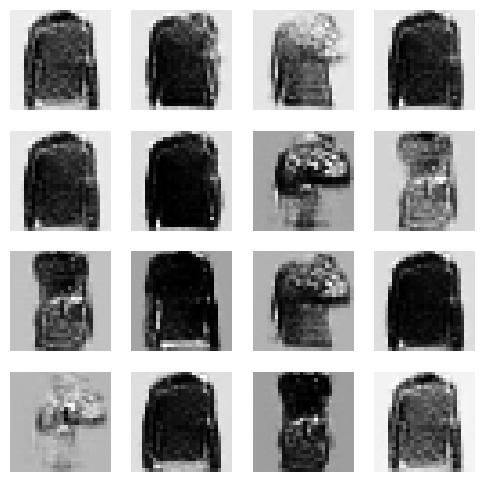

Época 25 de 1000
Pérdida del discriminador: 0.7291057109832764, Pérdida del generador: 1.8361480236053467
Pérdida del discriminador: 0.7174849510192871, Pérdida del generador: 1.9353827238082886
Pérdida del discriminador: 0.7110682725906372, Pérdida del generador: 1.9193929433822632
Pérdida del discriminador: 0.7558446526527405, Pérdida del generador: 1.89961576461792
Pérdida del discriminador: 0.6914288997650146, Pérdida del generador: 1.9575015306472778
Pérdida del discriminador: 0.7725906372070312, Pérdida del generador: 1.8545119762420654
Pérdida del discriminador: 0.6492815017700195, Pérdida del generador: 1.9305369853973389
Pérdida del discriminador: 0.7881565690040588, Pérdida del generador: 1.8583687543869019
Pérdida del discriminador: 0.7012317180633545, Pérdida del generador: 1.8422634601593018
Pérdida del discriminador: 0.6314073801040649, Pérdida del generador: 1.8931386470794678
Pérdida del discriminador: 0.6735159158706665, Pérdida del generador: 1.9526289701461792
Pérdid

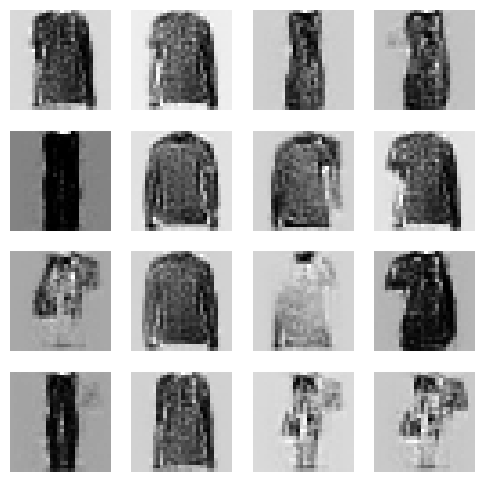

Época 27 de 1000
Pérdida del discriminador: 0.654882550239563, Pérdida del generador: 1.98724365234375
Pérdida del discriminador: 0.7698557376861572, Pérdida del generador: 1.7924456596374512
Pérdida del discriminador: 0.6864084005355835, Pérdida del generador: 1.6890426874160767
Pérdida del discriminador: 0.7372554540634155, Pérdida del generador: 1.7405732870101929
Pérdida del discriminador: 0.681318461894989, Pérdida del generador: 1.9855756759643555
Pérdida del discriminador: 0.6821768283843994, Pérdida del generador: 2.211611747741699
Pérdida del discriminador: 0.8025808334350586, Pérdida del generador: 2.179633378982544
Pérdida del discriminador: 0.6773216724395752, Pérdida del generador: 1.9560441970825195
Pérdida del discriminador: 0.7275609374046326, Pérdida del generador: 1.8235104084014893
Pérdida del discriminador: 0.653327465057373, Pérdida del generador: 1.7176270484924316
Pérdida del discriminador: 0.7128853797912598, Pérdida del generador: 1.7138720750808716
Pérdida del

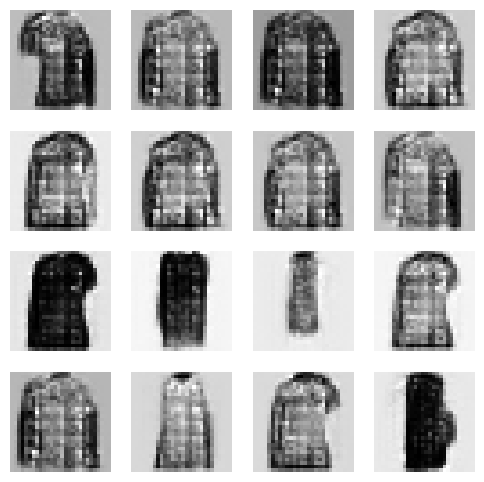

Época 29 de 1000
Pérdida del discriminador: 0.5670211315155029, Pérdida del generador: 2.262411594390869
Pérdida del discriminador: 0.5742582082748413, Pérdida del generador: 2.2308149337768555
Pérdida del discriminador: 0.6538887023925781, Pérdida del generador: 2.210164785385132
Pérdida del discriminador: 0.656740128993988, Pérdida del generador: 2.2201242446899414
Pérdida del discriminador: 0.6728474497795105, Pérdida del generador: 2.2924423217773438
Pérdida del discriminador: 0.6515744924545288, Pérdida del generador: 2.240924596786499
Pérdida del discriminador: 0.6327625513076782, Pérdida del generador: 2.1483888626098633
Pérdida del discriminador: 0.7403618097305298, Pérdida del generador: 1.9774081707000732
Pérdida del discriminador: 0.669698178768158, Pérdida del generador: 2.0014686584472656
Pérdida del discriminador: 0.6531894207000732, Pérdida del generador: 2.1012518405914307
Pérdida del discriminador: 0.7206999063491821, Pérdida del generador: 2.1509835720062256
Pérdida d

2025-02-11 18:19:44.484479: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


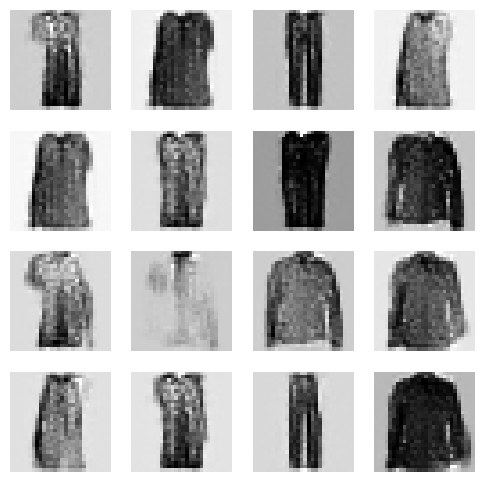

Época 31 de 1000
Pérdida del discriminador: 0.6252474188804626, Pérdida del generador: 1.8077764511108398
Pérdida del discriminador: 0.6418437957763672, Pérdida del generador: 1.9073967933654785
Pérdida del discriminador: 0.7092609405517578, Pérdida del generador: 2.019869804382324
Pérdida del discriminador: 0.7329697012901306, Pérdida del generador: 2.0937533378601074
Pérdida del discriminador: 0.6774775981903076, Pérdida del generador: 2.0027291774749756
Pérdida del discriminador: 0.6698516607284546, Pérdida del generador: 1.9460082054138184
Pérdida del discriminador: 0.6174514889717102, Pérdida del generador: 1.950183629989624
Pérdida del discriminador: 0.6326110363006592, Pérdida del generador: 1.9883979558944702
Pérdida del discriminador: 0.6569271683692932, Pérdida del generador: 2.092437267303467
Pérdida del discriminador: 0.619373619556427, Pérdida del generador: 2.0401036739349365
Pérdida del discriminador: 0.6787364482879639, Pérdida del generador: 2.0116119384765625
Pérdida 

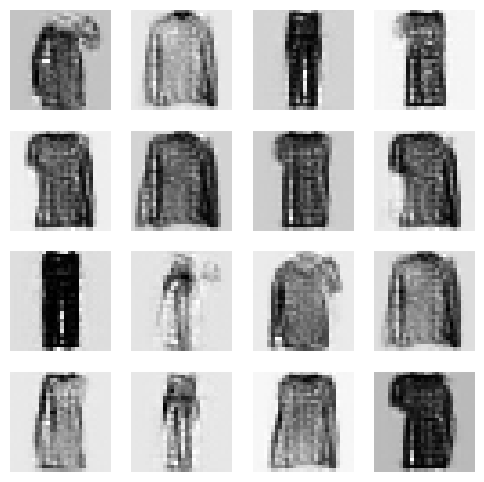

Época 33 de 1000
Pérdida del discriminador: 0.6655144095420837, Pérdida del generador: 2.1566524505615234
Pérdida del discriminador: 0.661966860294342, Pérdida del generador: 2.125203847885132
Pérdida del discriminador: 0.5943613052368164, Pérdida del generador: 2.13283109664917
Pérdida del discriminador: 0.6693441271781921, Pérdida del generador: 1.9703117609024048
Pérdida del discriminador: 0.7418655157089233, Pérdida del generador: 1.8941248655319214
Pérdida del discriminador: 0.6599459648132324, Pérdida del generador: 1.9481804370880127
Pérdida del discriminador: 0.7050904035568237, Pérdida del generador: 1.9877742528915405
Pérdida del discriminador: 0.831574559211731, Pérdida del generador: 1.9654560089111328
Pérdida del discriminador: 0.658788800239563, Pérdida del generador: 2.0591487884521484
Pérdida del discriminador: 0.7522665858268738, Pérdida del generador: 2.119495391845703
Pérdida del discriminador: 0.7332638502120972, Pérdida del generador: 2.0683727264404297
Pérdida del

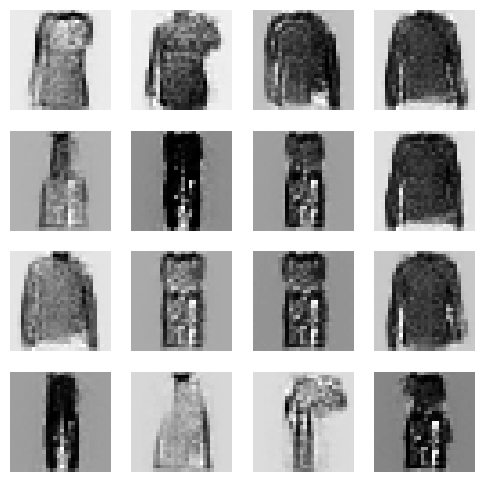

Época 35 de 1000
Pérdida del discriminador: 0.7110159397125244, Pérdida del generador: 1.9639097452163696
Pérdida del discriminador: 0.6302441358566284, Pérdida del generador: 1.9079488515853882
Pérdida del discriminador: 0.7391364574432373, Pérdida del generador: 1.9502270221710205
Pérdida del discriminador: 0.8670718669891357, Pérdida del generador: 1.960679054260254
Pérdida del discriminador: 0.712149977684021, Pérdida del generador: 2.134827136993408
Pérdida del discriminador: 0.7427847385406494, Pérdida del generador: 2.2172441482543945
Pérdida del discriminador: 0.8157578706741333, Pérdida del generador: 2.106584072113037
Pérdida del discriminador: 0.6842024326324463, Pérdida del generador: 1.9179234504699707
Pérdida del discriminador: 0.7814834117889404, Pérdida del generador: 1.867527961730957
Pérdida del discriminador: 0.7807826995849609, Pérdida del generador: 1.7950233221054077
Pérdida del discriminador: 0.7247239351272583, Pérdida del generador: 1.8685327768325806
Pérdida d

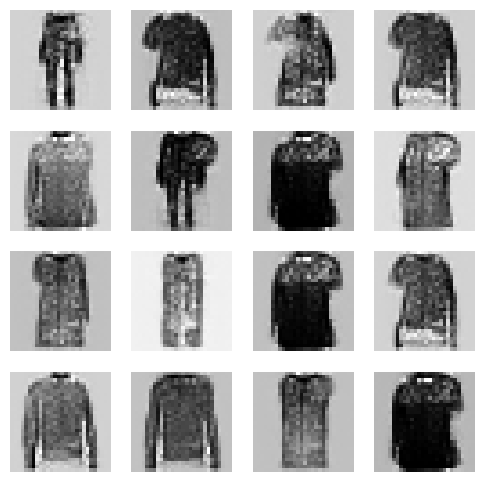

Época 37 de 1000
Pérdida del discriminador: 0.7832369208335876, Pérdida del generador: 1.9631998538970947
Pérdida del discriminador: 0.8051698207855225, Pérdida del generador: 1.7578198909759521
Pérdida del discriminador: 0.673527717590332, Pérdida del generador: 1.6936813592910767
Pérdida del discriminador: 0.7020831108093262, Pérdida del generador: 1.790117859840393
Pérdida del discriminador: 0.706978440284729, Pérdida del generador: 2.0511348247528076
Pérdida del discriminador: 0.737274706363678, Pérdida del generador: 2.1475720405578613
Pérdida del discriminador: 0.7510113716125488, Pérdida del generador: 2.0614657402038574
Pérdida del discriminador: 0.7718433737754822, Pérdida del generador: 1.9599847793579102
Pérdida del discriminador: 0.7228281497955322, Pérdida del generador: 1.7771717309951782
Pérdida del discriminador: 0.7240781784057617, Pérdida del generador: 1.6570448875427246
Pérdida del discriminador: 0.7381318211555481, Pérdida del generador: 1.7728569507598877
Pérdida 

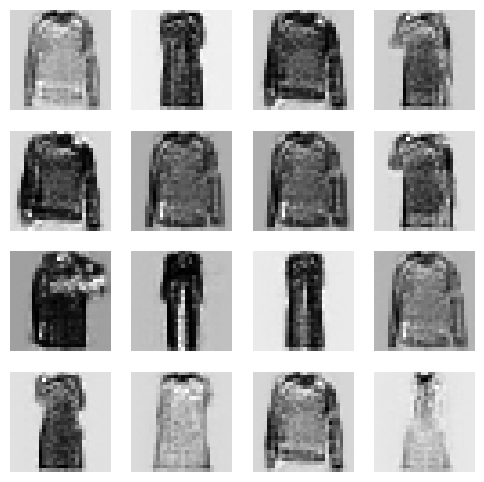

Época 39 de 1000
Pérdida del discriminador: 0.6925884485244751, Pérdida del generador: 1.9974552392959595
Pérdida del discriminador: 0.6791542768478394, Pérdida del generador: 2.0273425579071045
Pérdida del discriminador: 0.721288800239563, Pérdida del generador: 2.0266177654266357
Pérdida del discriminador: 0.673804759979248, Pérdida del generador: 1.9757130146026611
Pérdida del discriminador: 0.7109684944152832, Pérdida del generador: 1.9162861108779907
Pérdida del discriminador: 0.7265852689743042, Pérdida del generador: 1.8833024501800537
Pérdida del discriminador: 0.714974045753479, Pérdida del generador: 1.9482163190841675
Pérdida del discriminador: 0.7117079496383667, Pérdida del generador: 2.065413236618042
Pérdida del discriminador: 0.7565133571624756, Pérdida del generador: 1.9521441459655762
Pérdida del discriminador: 0.6880320310592651, Pérdida del generador: 1.8867661952972412
Pérdida del discriminador: 0.7757601737976074, Pérdida del generador: 1.7653095722198486
Pérdida 

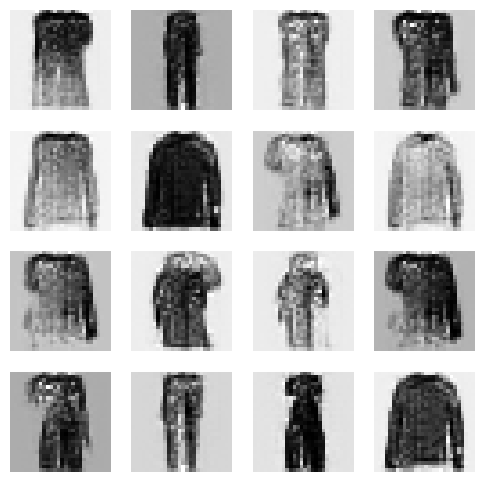

Época 41 de 1000
Pérdida del discriminador: 0.7690098285675049, Pérdida del generador: 1.6193784475326538
Pérdida del discriminador: 0.6793532371520996, Pérdida del generador: 1.7523236274719238
Pérdida del discriminador: 0.6991556286811829, Pérdida del generador: 2.0397191047668457
Pérdida del discriminador: 0.7847551107406616, Pérdida del generador: 2.174426794052124
Pérdida del discriminador: 0.7741611003875732, Pérdida del generador: 2.169517993927002
Pérdida del discriminador: 0.7413632273674011, Pérdida del generador: 1.8456178903579712
Pérdida del discriminador: 0.7425961494445801, Pérdida del generador: 1.5749914646148682
Pérdida del discriminador: 0.736874520778656, Pérdida del generador: 1.7101308107376099
Pérdida del discriminador: 0.7338119745254517, Pérdida del generador: 2.010197639465332
Pérdida del discriminador: 0.7087758779525757, Pérdida del generador: 2.293843984603882
Pérdida del discriminador: 0.8052809238433838, Pérdida del generador: 2.3059957027435303
Pérdida d

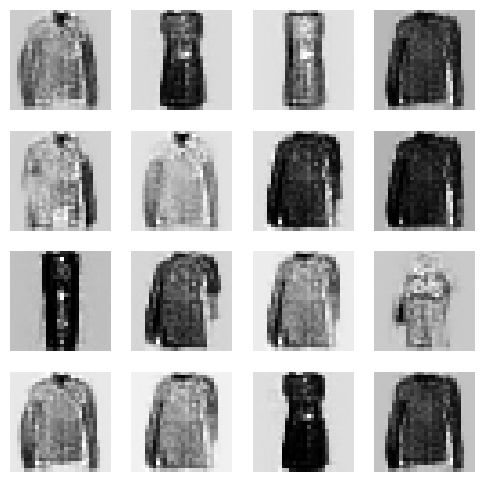

Época 43 de 1000
Pérdida del discriminador: 0.7001370191574097, Pérdida del generador: 1.9753775596618652
Pérdida del discriminador: 0.715969979763031, Pérdida del generador: 2.051583766937256
Pérdida del discriminador: 0.69347083568573, Pérdida del generador: 2.160050392150879
Pérdida del discriminador: 0.7897359728813171, Pérdida del generador: 2.195725679397583
Pérdida del discriminador: 0.7025133371353149, Pérdida del generador: 2.092620849609375
Pérdida del discriminador: 0.6978186368942261, Pérdida del generador: 1.887216567993164
Pérdida del discriminador: 0.749077320098877, Pérdida del generador: 1.8585819005966187
Pérdida del discriminador: 0.6866953372955322, Pérdida del generador: 1.8730666637420654
Pérdida del discriminador: 0.7092366218566895, Pérdida del generador: 2.0170469284057617
Pérdida del discriminador: 0.6521531343460083, Pérdida del generador: 2.1342062950134277
Pérdida del discriminador: 0.7687091827392578, Pérdida del generador: 2.1795127391815186
Pérdida del d

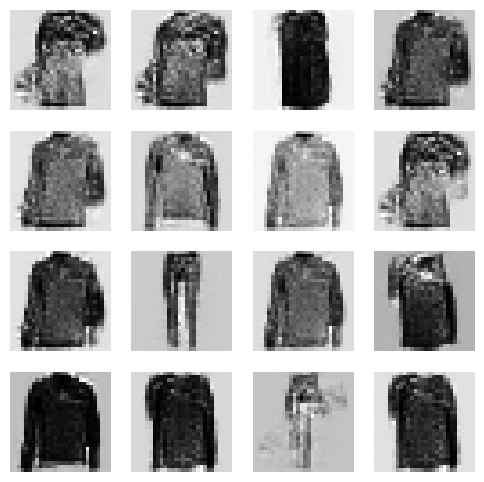

Época 45 de 1000
Pérdida del discriminador: 0.7679610848426819, Pérdida del generador: 2.0287842750549316
Pérdida del discriminador: 0.7536495923995972, Pérdida del generador: 1.8973253965377808
Pérdida del discriminador: 0.8024465441703796, Pérdida del generador: 1.7600812911987305
Pérdida del discriminador: 0.8745242357254028, Pérdida del generador: 1.6625573635101318
Pérdida del discriminador: 0.8034378290176392, Pérdida del generador: 1.6845563650131226
Pérdida del discriminador: 0.8028461337089539, Pérdida del generador: 1.8234319686889648
Pérdida del discriminador: 0.6521454453468323, Pérdida del generador: 2.007730007171631
Pérdida del discriminador: 0.8167298436164856, Pérdida del generador: 2.044712543487549
Pérdida del discriminador: 0.7768248915672302, Pérdida del generador: 1.837822437286377
Pérdida del discriminador: 0.7440961599349976, Pérdida del generador: 1.8180536031723022
Pérdida del discriminador: 0.7514837980270386, Pérdida del generador: 1.7297658920288086
Pérdida

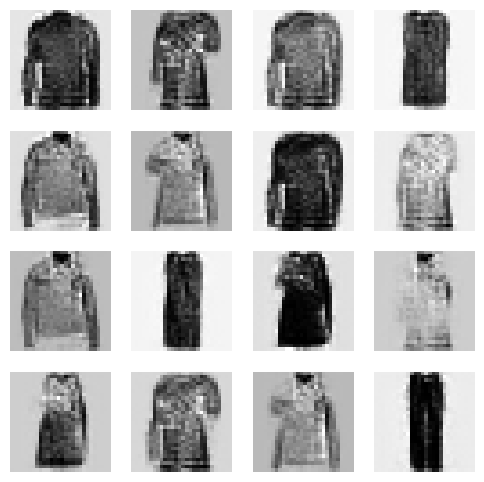

Época 47 de 1000
Pérdida del discriminador: 0.7169582843780518, Pérdida del generador: 1.8071306943893433
Pérdida del discriminador: 0.7341787219047546, Pérdida del generador: 1.765053629875183
Pérdida del discriminador: 0.684611439704895, Pérdida del generador: 1.9939086437225342
Pérdida del discriminador: 0.6364045739173889, Pérdida del generador: 2.1772797107696533
Pérdida del discriminador: 0.7192320227622986, Pérdida del generador: 2.2405223846435547
Pérdida del discriminador: 0.6926272511482239, Pérdida del generador: 2.102687358856201
Pérdida del discriminador: 0.6540170311927795, Pérdida del generador: 2.026817560195923
Pérdida del discriminador: 0.7242567539215088, Pérdida del generador: 1.8362560272216797
Pérdida del discriminador: 0.6203104257583618, Pérdida del generador: 1.9558156728744507
Pérdida del discriminador: 0.6958860158920288, Pérdida del generador: 2.0292375087738037
Pérdida del discriminador: 0.7333817481994629, Pérdida del generador: 2.0303022861480713
Pérdida 

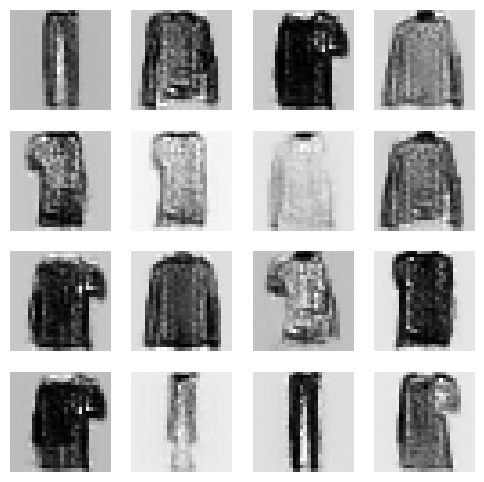

Época 49 de 1000
Pérdida del discriminador: 0.6857762932777405, Pérdida del generador: 2.1256237030029297
Pérdida del discriminador: 0.6919853687286377, Pérdida del generador: 1.968116044998169
Pérdida del discriminador: 0.7278406620025635, Pérdida del generador: 1.9186601638793945
Pérdida del discriminador: 0.66585373878479, Pérdida del generador: 1.971909523010254
Pérdida del discriminador: 0.7196071147918701, Pérdida del generador: 1.9790809154510498
Pérdida del discriminador: 0.7024829983711243, Pérdida del generador: 2.1006035804748535
Pérdida del discriminador: 0.6139065027236938, Pérdida del generador: 2.174368143081665
Pérdida del discriminador: 0.6694169044494629, Pérdida del generador: 2.1427745819091797
Pérdida del discriminador: 0.7247918248176575, Pérdida del generador: 1.9810280799865723
Pérdida del discriminador: 0.7607885599136353, Pérdida del generador: 1.9518526792526245
Pérdida del discriminador: 0.6997106671333313, Pérdida del generador: 2.0001065731048584
Pérdida d

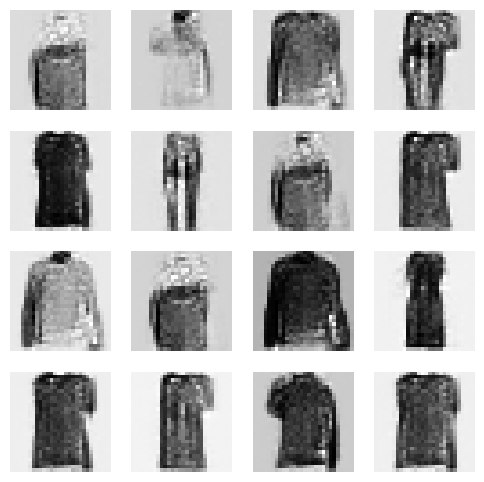

Época 51 de 1000
Pérdida del discriminador: 0.6424815058708191, Pérdida del generador: 2.209730625152588
Pérdida del discriminador: 0.6613764762878418, Pérdida del generador: 2.1841073036193848
Pérdida del discriminador: 0.6727215647697449, Pérdida del generador: 1.9936752319335938
Pérdida del discriminador: 0.6611435413360596, Pérdida del generador: 1.9949594736099243
Pérdida del discriminador: 0.6785178184509277, Pérdida del generador: 1.965195655822754
Pérdida del discriminador: 0.6584705114364624, Pérdida del generador: 2.0756635665893555
Pérdida del discriminador: 0.7029496431350708, Pérdida del generador: 2.1495659351348877
Pérdida del discriminador: 0.6656699180603027, Pérdida del generador: 2.16176700592041
Pérdida del discriminador: 0.629906952381134, Pérdida del generador: 2.147301197052002
Pérdida del discriminador: 0.5849317908287048, Pérdida del generador: 2.145581007003784
Pérdida del discriminador: 0.6642839908599854, Pérdida del generador: 2.144214630126953
Pérdida del 

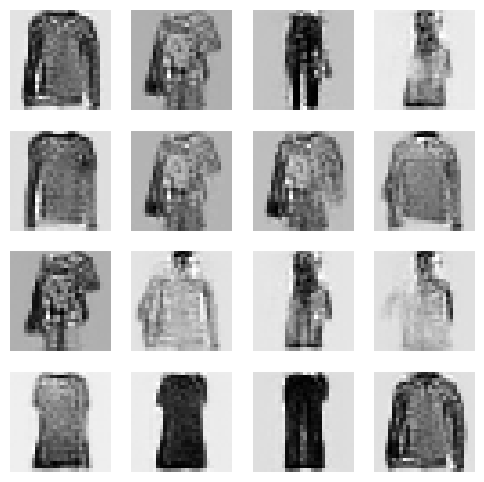

Época 53 de 1000
Pérdida del discriminador: 0.7517940998077393, Pérdida del generador: 1.8030089139938354
Pérdida del discriminador: 0.7302100658416748, Pérdida del generador: 1.7006826400756836
Pérdida del discriminador: 0.7920354604721069, Pérdida del generador: 1.8207409381866455
Pérdida del discriminador: 0.7383193969726562, Pérdida del generador: 2.045123338699341
Pérdida del discriminador: 0.7005258798599243, Pérdida del generador: 2.195077896118164
Pérdida del discriminador: 0.8020514249801636, Pérdida del generador: 2.115963935852051
Pérdida del discriminador: 0.7161610126495361, Pérdida del generador: 1.9570856094360352
Pérdida del discriminador: 0.7344554662704468, Pérdida del generador: 1.8772015571594238
Pérdida del discriminador: 0.6812689304351807, Pérdida del generador: 1.9148564338684082
Pérdida del discriminador: 0.7099676132202148, Pérdida del generador: 1.9252192974090576
Pérdida del discriminador: 0.6991214752197266, Pérdida del generador: 2.075410842895508
Pérdida 

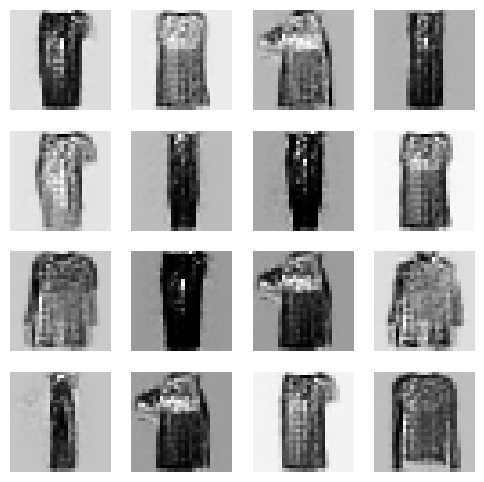

Época 55 de 1000
Pérdida del discriminador: 0.6752278804779053, Pérdida del generador: 2.2488818168640137
Pérdida del discriminador: 0.6857017278671265, Pérdida del generador: 2.2968568801879883
Pérdida del discriminador: 0.6660801768302917, Pérdida del generador: 2.3212647438049316
Pérdida del discriminador: 0.6462299823760986, Pérdida del generador: 2.2658257484436035
Pérdida del discriminador: 0.6709820032119751, Pérdida del generador: 2.1188275814056396
Pérdida del discriminador: 0.6557085514068604, Pérdida del generador: 2.124159812927246
Pérdida del discriminador: 0.6160411238670349, Pérdida del generador: 2.075373649597168
Pérdida del discriminador: 0.6995608806610107, Pérdida del generador: 2.1265053749084473
Pérdida del discriminador: 0.6009785532951355, Pérdida del generador: 2.219773530960083
Pérdida del discriminador: 0.6393706798553467, Pérdida del generador: 2.3799076080322266
Pérdida del discriminador: 0.6377490758895874, Pérdida del generador: 2.383596897125244
Pérdida 

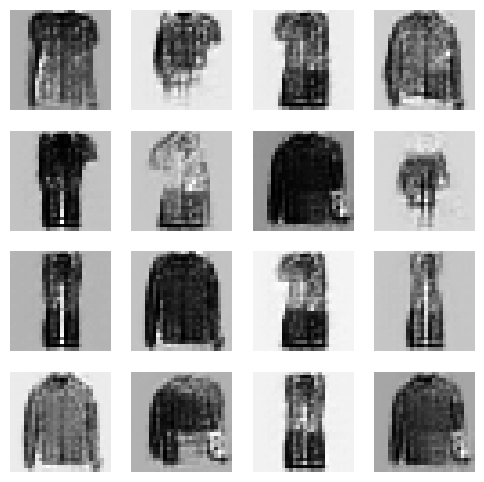

Época 57 de 1000
Pérdida del discriminador: 0.7402293086051941, Pérdida del generador: 1.8711979389190674
Pérdida del discriminador: 0.7873047590255737, Pérdida del generador: 1.775761604309082
Pérdida del discriminador: 0.8318427205085754, Pérdida del generador: 1.9787027835845947
Pérdida del discriminador: 0.8569799661636353, Pérdida del generador: 2.234285354614258
Pérdida del discriminador: 0.7656261920928955, Pérdida del generador: 2.548403739929199
Pérdida del discriminador: 0.770329475402832, Pérdida del generador: 2.5294137001037598
Pérdida del discriminador: 0.8176133632659912, Pérdida del generador: 2.135265588760376
Pérdida del discriminador: 0.753345787525177, Pérdida del generador: 1.8143997192382812
Pérdida del discriminador: 0.8497855067253113, Pérdida del generador: 1.7322752475738525
Pérdida del discriminador: 0.7497668862342834, Pérdida del generador: 1.8771209716796875
Pérdida del discriminador: 0.8504977226257324, Pérdida del generador: 2.192993402481079
Pérdida del

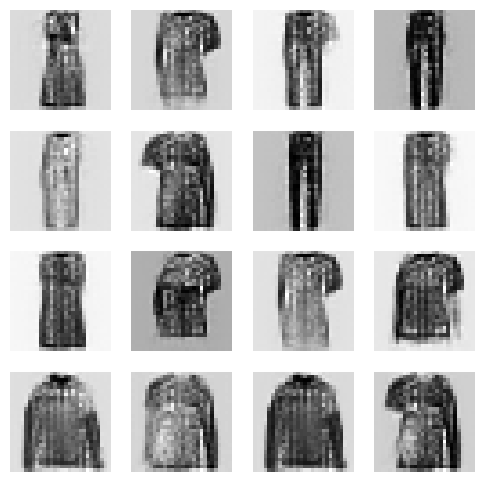

Época 59 de 1000
Pérdida del discriminador: 0.7427977323532104, Pérdida del generador: 2.0661661624908447
Pérdida del discriminador: 0.761077880859375, Pérdida del generador: 1.9265611171722412
Pérdida del discriminador: 0.7704563140869141, Pérdida del generador: 1.995553731918335
Pérdida del discriminador: 0.7154786586761475, Pérdida del generador: 2.1047966480255127
Pérdida del discriminador: 0.7769168019294739, Pérdida del generador: 2.1302683353424072
Pérdida del discriminador: 0.7060724496841431, Pérdida del generador: 2.0374860763549805
Pérdida del discriminador: 0.7165758013725281, Pérdida del generador: 1.9291484355926514
Pérdida del discriminador: 0.7130757570266724, Pérdida del generador: 1.9623442888259888
Pérdida del discriminador: 0.6778276562690735, Pérdida del generador: 2.029536247253418
Pérdida del discriminador: 0.564751148223877, Pérdida del generador: 2.2300150394439697
Pérdida del discriminador: 0.5906292200088501, Pérdida del generador: 2.4689464569091797
Pérdida 

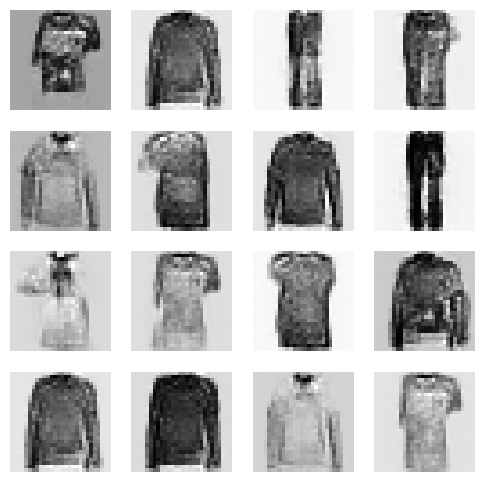

Época 61 de 1000
Pérdida del discriminador: 0.6819806098937988, Pérdida del generador: 1.9159725904464722
Pérdida del discriminador: 0.70028156042099, Pérdida del generador: 2.065495014190674
Pérdida del discriminador: 0.7113974094390869, Pérdida del generador: 2.1414029598236084
Pérdida del discriminador: 0.6590712070465088, Pérdida del generador: 2.236738681793213
Pérdida del discriminador: 0.6433897018432617, Pérdida del generador: 2.1963539123535156
Pérdida del discriminador: 0.8073657751083374, Pérdida del generador: 1.8864936828613281
Pérdida del discriminador: 0.5767854452133179, Pérdida del generador: 2.042719841003418
Pérdida del discriminador: 0.7321195006370544, Pérdida del generador: 1.9826875925064087
Pérdida del discriminador: 0.6768757104873657, Pérdida del generador: 2.1351828575134277
Pérdida del discriminador: 0.6387044191360474, Pérdida del generador: 2.169590711593628
Pérdida del discriminador: 0.7334579825401306, Pérdida del generador: 2.144380569458008
Pérdida del

2025-02-11 19:36:24.913475: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


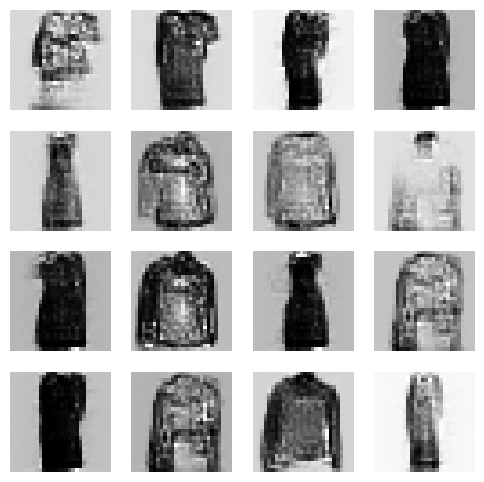

Época 63 de 1000
Pérdida del discriminador: 0.6014970541000366, Pérdida del generador: 2.122337818145752
Pérdida del discriminador: 0.6674098372459412, Pérdida del generador: 2.193357467651367
Pérdida del discriminador: 0.5388163924217224, Pérdida del generador: 2.3932864665985107
Pérdida del discriminador: 0.6831998229026794, Pérdida del generador: 2.4288363456726074
Pérdida del discriminador: 0.5882778167724609, Pérdida del generador: 2.426185131072998
Pérdida del discriminador: 0.6842838525772095, Pérdida del generador: 2.4183297157287598
Pérdida del discriminador: 0.6267400979995728, Pérdida del generador: 2.2983298301696777
Pérdida del discriminador: 0.5770218372344971, Pérdida del generador: 2.3263583183288574
Pérdida del discriminador: 0.5908602476119995, Pérdida del generador: 2.407545566558838
Pérdida del discriminador: 0.6145254373550415, Pérdida del generador: 2.4558839797973633
Pérdida del discriminador: 0.6565607786178589, Pérdida del generador: 2.3207645416259766
Pérdida 

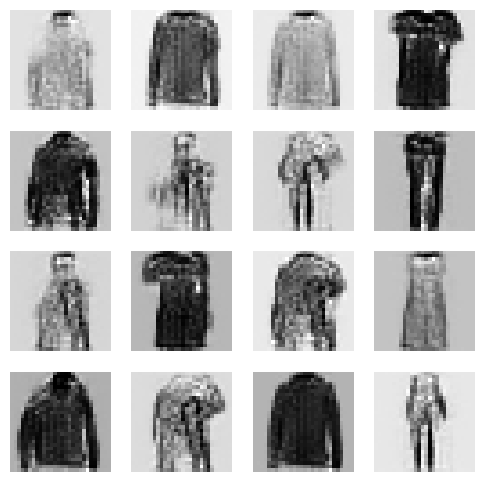

Época 65 de 1000
Pérdida del discriminador: 0.5372265577316284, Pérdida del generador: 2.2547972202301025
Pérdida del discriminador: 0.6654478311538696, Pérdida del generador: 2.1473631858825684
Pérdida del discriminador: 0.6563485860824585, Pérdida del generador: 2.155503749847412
Pérdida del discriminador: 0.6380035877227783, Pérdida del generador: 2.232621669769287
Pérdida del discriminador: 0.6984601616859436, Pérdida del generador: 2.2752437591552734
Pérdida del discriminador: 0.6394190788269043, Pérdida del generador: 2.335923671722412
Pérdida del discriminador: 0.6448065638542175, Pérdida del generador: 2.280346393585205
Pérdida del discriminador: 0.6481505036354065, Pérdida del generador: 2.2413558959960938
Pérdida del discriminador: 0.5903663635253906, Pérdida del generador: 2.0527734756469727
Pérdida del discriminador: 0.6415349245071411, Pérdida del generador: 2.0049922466278076
Pérdida del discriminador: 0.6389487385749817, Pérdida del generador: 2.155597686767578
Pérdida d

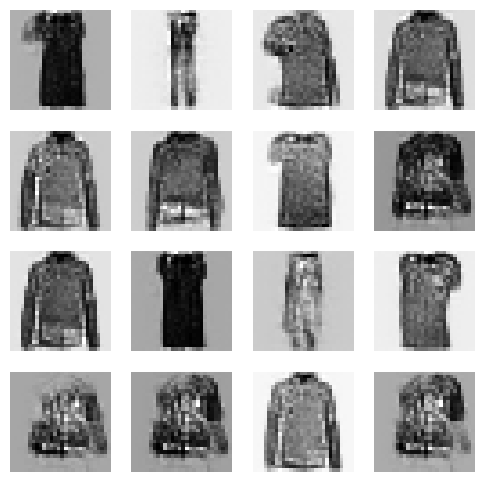

Época 67 de 1000
Pérdida del discriminador: 0.7092187404632568, Pérdida del generador: 2.295496940612793
Pérdida del discriminador: 0.6346243023872375, Pérdida del generador: 2.4033098220825195
Pérdida del discriminador: 0.591465950012207, Pérdida del generador: 2.462508201599121
Pérdida del discriminador: 0.7269806265830994, Pérdida del generador: 2.2339797019958496
Pérdida del discriminador: 0.6835484504699707, Pérdida del generador: 2.0168302059173584
Pérdida del discriminador: 0.7497080564498901, Pérdida del generador: 1.9020607471466064
Pérdida del discriminador: 0.6707504391670227, Pérdida del generador: 1.980370044708252
Pérdida del discriminador: 0.6487922668457031, Pérdida del generador: 2.187636375427246
Pérdida del discriminador: 0.6167740225791931, Pérdida del generador: 2.4831418991088867
Pérdida del discriminador: 0.621288001537323, Pérdida del generador: 2.5484392642974854
Pérdida del discriminador: 0.7645132541656494, Pérdida del generador: 2.2729592323303223
Pérdida de

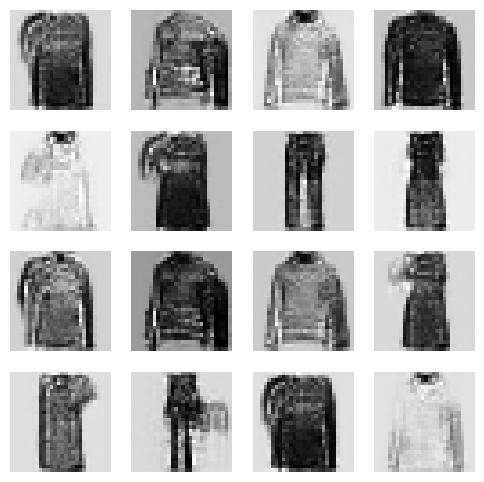

Época 69 de 1000
Pérdida del discriminador: 0.6541833877563477, Pérdida del generador: 2.1550798416137695
Pérdida del discriminador: 0.6790448427200317, Pérdida del generador: 2.1511940956115723
Pérdida del discriminador: 0.7182556390762329, Pérdida del generador: 2.171299934387207
Pérdida del discriminador: 0.6333164572715759, Pérdida del generador: 2.2457265853881836
Pérdida del discriminador: 0.6437656879425049, Pérdida del generador: 2.2897567749023438
Pérdida del discriminador: 0.6636946201324463, Pérdida del generador: 2.122128486633301
Pérdida del discriminador: 0.6462326049804688, Pérdida del generador: 2.036132574081421
Pérdida del discriminador: 0.7239929437637329, Pérdida del generador: 2.1152467727661133
Pérdida del discriminador: 0.6061230897903442, Pérdida del generador: 2.3207039833068848
Pérdida del discriminador: 0.6350151300430298, Pérdida del generador: 2.334268093109131
Pérdida del discriminador: 0.6854267716407776, Pérdida del generador: 2.3225655555725098
Pérdida 

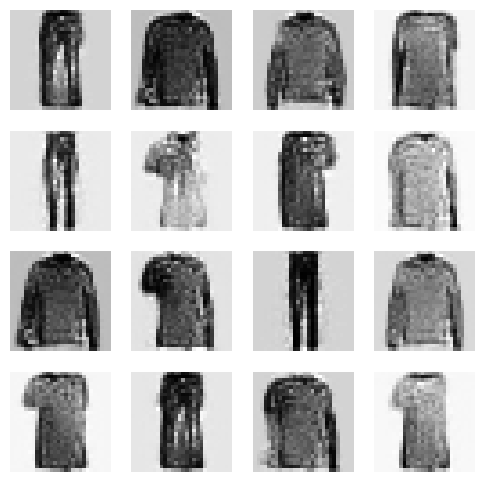

Época 71 de 1000
Pérdida del discriminador: 0.6703343391418457, Pérdida del generador: 2.2905170917510986
Pérdida del discriminador: 0.7182525396347046, Pérdida del generador: 2.2046761512756348
Pérdida del discriminador: 0.7467270493507385, Pérdida del generador: 2.099238634109497
Pérdida del discriminador: 0.6677422523498535, Pérdida del generador: 2.0817723274230957
Pérdida del discriminador: 0.6947018504142761, Pérdida del generador: 2.2453389167785645
Pérdida del discriminador: 0.7716562747955322, Pérdida del generador: 2.305140256881714
Pérdida del discriminador: 0.718451738357544, Pérdida del generador: 2.278721332550049
Pérdida del discriminador: 0.7061078548431396, Pérdida del generador: 2.253535509109497
Pérdida del discriminador: 0.6610691547393799, Pérdida del generador: 2.1582248210906982
Pérdida del discriminador: 0.8128238320350647, Pérdida del generador: 1.9552242755889893
Pérdida del discriminador: 0.7433011531829834, Pérdida del generador: 1.9412150382995605
Pérdida d

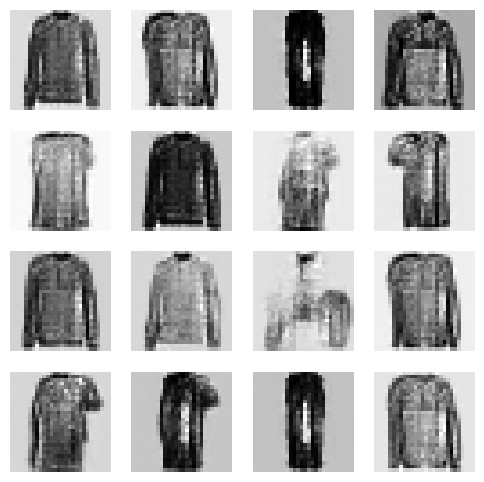

Época 73 de 1000
Pérdida del discriminador: 0.6569740176200867, Pérdida del generador: 2.047684669494629
Pérdida del discriminador: 0.6551933884620667, Pérdida del generador: 2.2743940353393555
Pérdida del discriminador: 0.6634856462478638, Pérdida del generador: 2.45660662651062
Pérdida del discriminador: 0.6629862785339355, Pérdida del generador: 2.370760440826416
Pérdida del discriminador: 0.647773265838623, Pérdida del generador: 2.2445573806762695
Pérdida del discriminador: 0.5810795426368713, Pérdida del generador: 2.1851253509521484
Pérdida del discriminador: 0.6055701375007629, Pérdida del generador: 2.236327886581421
Pérdida del discriminador: 0.6792740225791931, Pérdida del generador: 2.4038262367248535
Pérdida del discriminador: 0.6198508143424988, Pérdida del generador: 2.425039291381836
Pérdida del discriminador: 0.6871545314788818, Pérdida del generador: 2.311673164367676
Pérdida del discriminador: 0.6794970035552979, Pérdida del generador: 2.236818313598633
Pérdida del d

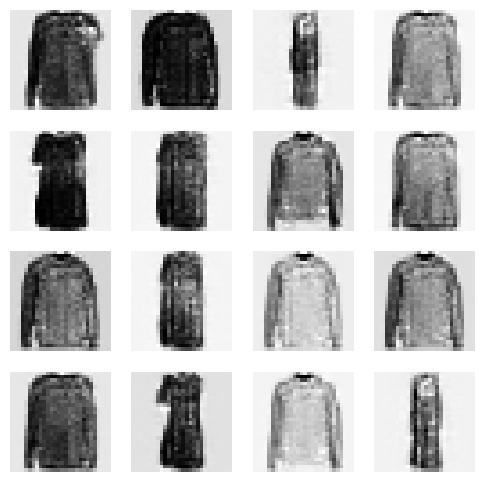

Época 75 de 1000
Pérdida del discriminador: 0.646186351776123, Pérdida del generador: 2.264431953430176
Pérdida del discriminador: 0.6394482851028442, Pérdida del generador: 2.241868495941162
Pérdida del discriminador: 0.6051931977272034, Pérdida del generador: 2.3022186756134033
Pérdida del discriminador: 0.6421424150466919, Pérdida del generador: 2.3862342834472656
Pérdida del discriminador: 0.5910918116569519, Pérdida del generador: 2.4023425579071045
Pérdida del discriminador: 0.5620999336242676, Pérdida del generador: 2.463493585586548
Pérdida del discriminador: 0.5949944853782654, Pérdida del generador: 2.364398956298828
Pérdida del discriminador: 0.6766126155853271, Pérdida del generador: 2.198911190032959
Pérdida del discriminador: 0.5435888767242432, Pérdida del generador: 2.2931017875671387
Pérdida del discriminador: 0.5466067790985107, Pérdida del generador: 2.4006264209747314
Pérdida del discriminador: 0.6381211280822754, Pérdida del generador: 2.4175708293914795
Pérdida de

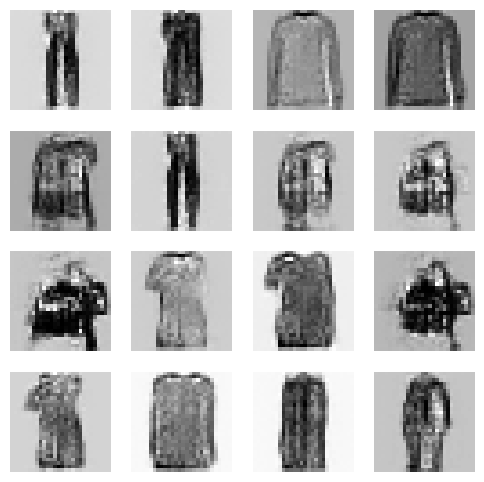

Época 77 de 1000
Pérdida del discriminador: 0.752299427986145, Pérdida del generador: 2.4485745429992676
Pérdida del discriminador: 0.7288333177566528, Pérdida del generador: 2.2719006538391113
Pérdida del discriminador: 0.5858117341995239, Pérdida del generador: 2.1464858055114746
Pérdida del discriminador: 0.6407352089881897, Pérdida del generador: 2.1284055709838867
Pérdida del discriminador: 0.6466735601425171, Pérdida del generador: 2.3239831924438477
Pérdida del discriminador: 0.6992127895355225, Pérdida del generador: 2.265981674194336
Pérdida del discriminador: 0.6381078958511353, Pérdida del generador: 2.332332134246826
Pérdida del discriminador: 0.656597912311554, Pérdida del generador: 2.2777132987976074
Pérdida del discriminador: 0.7364664673805237, Pérdida del generador: 2.132075786590576
Pérdida del discriminador: 0.6458184719085693, Pérdida del generador: 2.0829973220825195
Pérdida del discriminador: 0.6392626762390137, Pérdida del generador: 2.058403253555298
Pérdida de

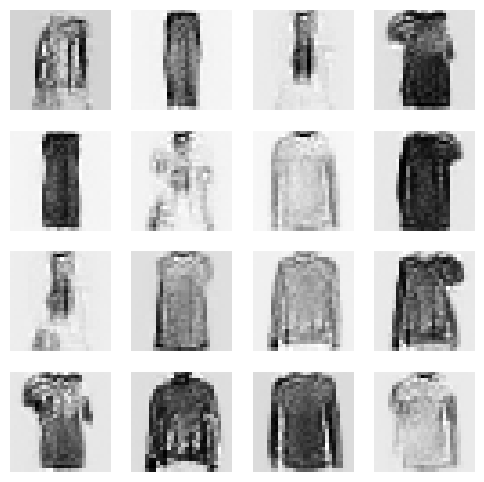

Época 79 de 1000
Pérdida del discriminador: 0.6704403162002563, Pérdida del generador: 2.1760520935058594
Pérdida del discriminador: 0.6407786011695862, Pérdida del generador: 2.202503204345703
Pérdida del discriminador: 0.6342597007751465, Pérdida del generador: 2.210869789123535
Pérdida del discriminador: 0.6302138566970825, Pérdida del generador: 2.2575230598449707
Pérdida del discriminador: 0.5390828251838684, Pérdida del generador: 2.427964210510254
Pérdida del discriminador: 0.7315503358840942, Pérdida del generador: 2.285412311553955
Pérdida del discriminador: 0.5830738544464111, Pérdida del generador: 2.19441819190979
Pérdida del discriminador: 0.5886616706848145, Pérdida del generador: 2.129417657852173
Pérdida del discriminador: 0.5881484746932983, Pérdida del generador: 2.1731069087982178
Pérdida del discriminador: 0.6529200673103333, Pérdida del generador: 2.261322498321533
Pérdida del discriminador: 0.6432353854179382, Pérdida del generador: 2.2668869495391846
Pérdida del 

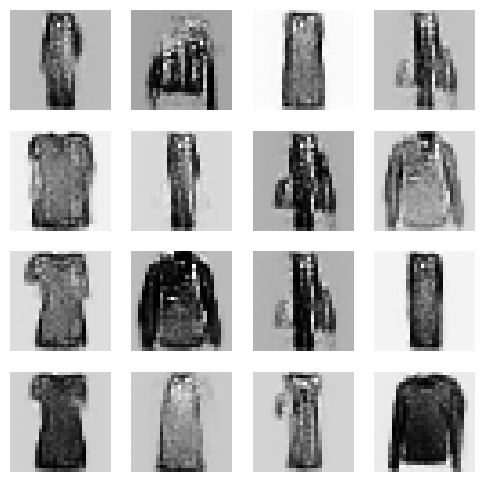

Época 81 de 1000
Pérdida del discriminador: 0.5722947120666504, Pérdida del generador: 2.388540267944336
Pérdida del discriminador: 0.6014068126678467, Pérdida del generador: 2.378887176513672
Pérdida del discriminador: 0.6625306606292725, Pérdida del generador: 2.2474098205566406
Pérdida del discriminador: 0.5650709867477417, Pérdida del generador: 2.2669339179992676
Pérdida del discriminador: 0.6875487565994263, Pérdida del generador: 2.2678298950195312
Pérdida del discriminador: 0.6427851319313049, Pérdida del generador: 2.277221441268921
Pérdida del discriminador: 0.589569091796875, Pérdida del generador: 2.3139901161193848
Pérdida del discriminador: 0.6712196469306946, Pérdida del generador: 2.2399559020996094
Pérdida del discriminador: 0.7329099178314209, Pérdida del generador: 2.2171995639801025
Pérdida del discriminador: 0.7596023082733154, Pérdida del generador: 2.2160849571228027
Pérdida del discriminador: 0.6907368898391724, Pérdida del generador: 2.3033101558685303
Pérdida 

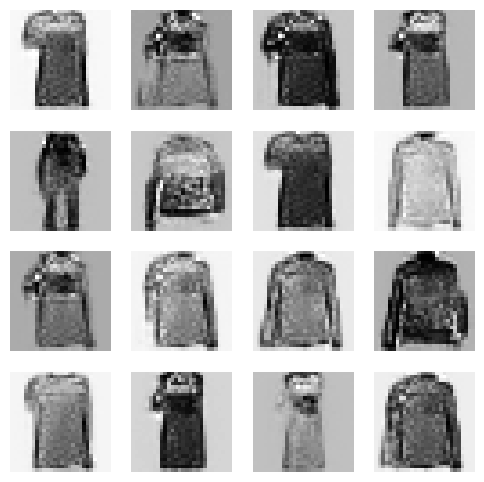

Época 83 de 1000
Pérdida del discriminador: 0.7300581336021423, Pérdida del generador: 2.06563663482666
Pérdida del discriminador: 0.7112180590629578, Pérdida del generador: 2.087038993835449
Pérdida del discriminador: 0.6234915256500244, Pérdida del generador: 2.150627851486206
Pérdida del discriminador: 0.7177132368087769, Pérdida del generador: 2.2292985916137695
Pérdida del discriminador: 0.7000001072883606, Pérdida del generador: 2.25113844871521
Pérdida del discriminador: 0.7548191547393799, Pérdida del generador: 2.328617572784424
Pérdida del discriminador: 0.6843622922897339, Pérdida del generador: 2.2110748291015625
Pérdida del discriminador: 0.7358056306838989, Pérdida del generador: 2.1779115200042725
Pérdida del discriminador: 0.712390661239624, Pérdida del generador: 2.254236936569214
Pérdida del discriminador: 0.7554075717926025, Pérdida del generador: 2.1009573936462402
Pérdida del discriminador: 0.6968425512313843, Pérdida del generador: 2.1600191593170166
Pérdida del d

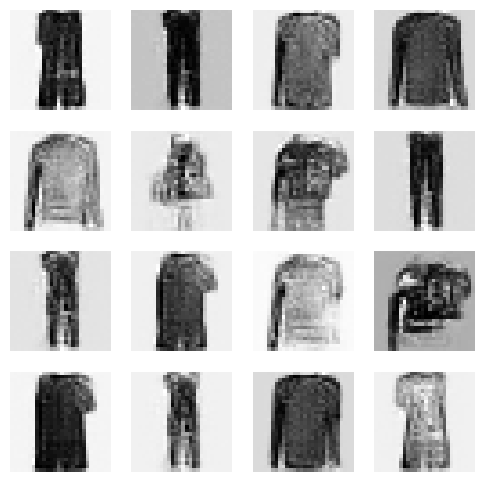

Época 85 de 1000
Pérdida del discriminador: 0.7561145424842834, Pérdida del generador: 2.1878249645233154
Pérdida del discriminador: 0.7151974439620972, Pérdida del generador: 2.23903751373291
Pérdida del discriminador: 0.7487419843673706, Pérdida del generador: 1.9864656925201416
Pérdida del discriminador: 0.6964772939682007, Pérdida del generador: 2.026939630508423
Pérdida del discriminador: 0.8241047263145447, Pérdida del generador: 2.0202624797821045
Pérdida del discriminador: 0.8289598226547241, Pérdida del generador: 2.1247591972351074
Pérdida del discriminador: 0.8263561725616455, Pérdida del generador: 2.1555545330047607
Pérdida del discriminador: 0.770510733127594, Pérdida del generador: 2.118837833404541
Pérdida del discriminador: 0.6882450580596924, Pérdida del generador: 2.1533994674682617
Pérdida del discriminador: 0.770451009273529, Pérdida del generador: 2.160256862640381
Pérdida del discriminador: 0.7011324167251587, Pérdida del generador: 2.227977752685547
Pérdida del 

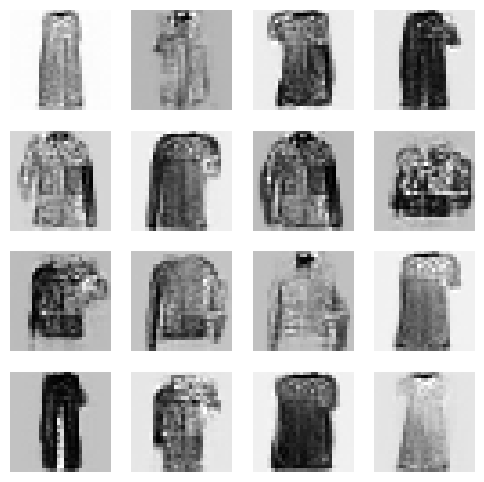

Época 87 de 1000
Pérdida del discriminador: 0.8120922446250916, Pérdida del generador: 1.9713327884674072
Pérdida del discriminador: 0.7634456157684326, Pérdida del generador: 2.0645370483398438
Pérdida del discriminador: 0.7240094542503357, Pérdida del generador: 2.097956657409668
Pérdida del discriminador: 0.8459441661834717, Pérdida del generador: 2.2036285400390625
Pérdida del discriminador: 0.6533201336860657, Pérdida del generador: 2.3445889949798584
Pérdida del discriminador: 0.753279447555542, Pérdida del generador: 2.4216415882110596
Pérdida del discriminador: 0.7786833047866821, Pérdida del generador: 2.129046678543091
Pérdida del discriminador: 0.8144264221191406, Pérdida del generador: 1.8532142639160156
Pérdida del discriminador: 0.773023784160614, Pérdida del generador: 1.7407139539718628
Pérdida del discriminador: 0.7970294952392578, Pérdida del generador: 1.8923547267913818
Pérdida del discriminador: 0.8194863796234131, Pérdida del generador: 2.108001947402954
Pérdida d

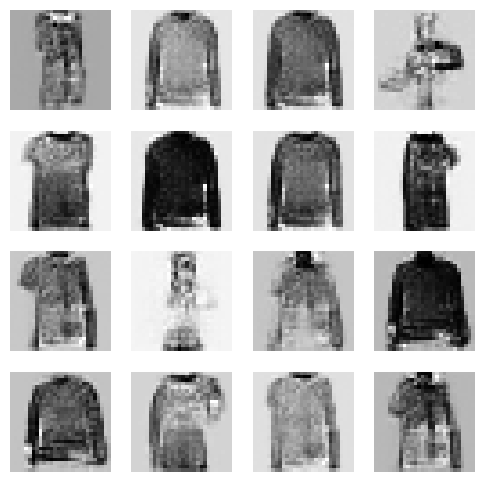

Época 89 de 1000
Pérdida del discriminador: 0.8576520681381226, Pérdida del generador: 2.1331467628479004
Pérdida del discriminador: 0.6685121059417725, Pérdida del generador: 1.894655704498291
Pérdida del discriminador: 0.7566393613815308, Pérdida del generador: 1.8358066082000732
Pérdida del discriminador: 0.7341632843017578, Pérdida del generador: 2.11411190032959
Pérdida del discriminador: 0.6652840375900269, Pérdida del generador: 2.4267897605895996
Pérdida del discriminador: 0.8136370778083801, Pérdida del generador: 2.6637067794799805
Pérdida del discriminador: 0.8032872676849365, Pérdida del generador: 2.428194761276245
Pérdida del discriminador: 0.7059972286224365, Pérdida del generador: 2.109673500061035
Pérdida del discriminador: 0.800858199596405, Pérdida del generador: 1.911253809928894
Pérdida del discriminador: 0.6491793394088745, Pérdida del generador: 1.9939539432525635
Pérdida del discriminador: 0.7461435794830322, Pérdida del generador: 2.223551034927368
Pérdida del 

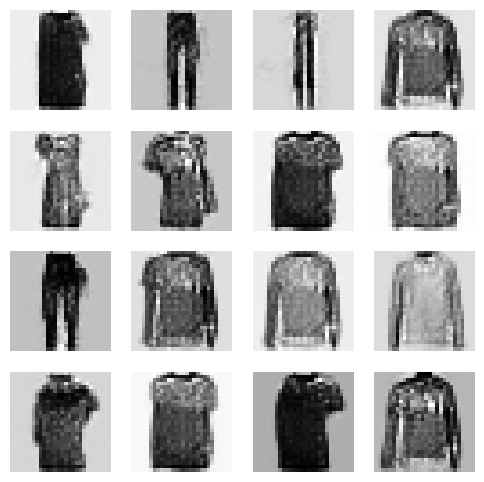

Época 91 de 1000
Pérdida del discriminador: 0.8046261668205261, Pérdida del generador: 2.193965435028076
Pérdida del discriminador: 0.8260382413864136, Pérdida del generador: 2.444901704788208
Pérdida del discriminador: 0.7512149810791016, Pérdida del generador: 2.3582310676574707
Pérdida del discriminador: 0.7546436190605164, Pérdida del generador: 2.0592098236083984
Pérdida del discriminador: 0.7801764011383057, Pérdida del generador: 1.7428401708602905
Pérdida del discriminador: 0.8478280305862427, Pérdida del generador: 1.7789747714996338
Pérdida del discriminador: 0.8194686770439148, Pérdida del generador: 2.063220739364624
Pérdida del discriminador: 0.8475048542022705, Pérdida del generador: 2.350703001022339
Pérdida del discriminador: 0.7461926937103271, Pérdida del generador: 2.3665781021118164
Pérdida del discriminador: 0.8788626194000244, Pérdida del generador: 2.1575706005096436
Pérdida del discriminador: 0.7713115215301514, Pérdida del generador: 1.8939892053604126
Pérdida 

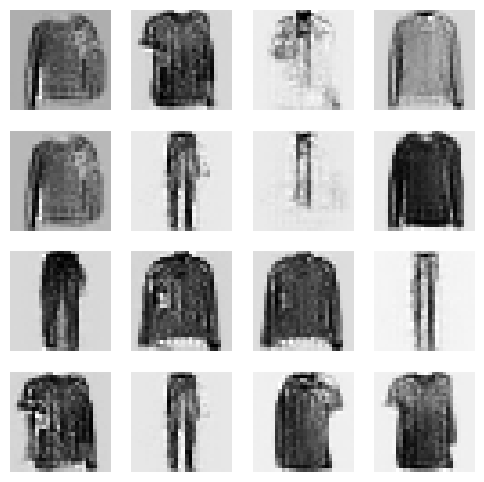

Época 93 de 1000
Pérdida del discriminador: 0.6521198153495789, Pérdida del generador: 2.4085259437561035
Pérdida del discriminador: 0.5989241003990173, Pérdida del generador: 2.4727935791015625
Pérdida del discriminador: 0.6477537155151367, Pérdida del generador: 2.44071102142334
Pérdida del discriminador: 0.6247762441635132, Pérdida del generador: 2.3085274696350098
Pérdida del discriminador: 0.6521024703979492, Pérdida del generador: 2.2328317165374756
Pérdida del discriminador: 0.6535527110099792, Pérdida del generador: 2.2865371704101562
Pérdida del discriminador: 0.7364028692245483, Pérdida del generador: 2.3100390434265137
Pérdida del discriminador: 0.7272274494171143, Pérdida del generador: 2.2486214637756348
Pérdida del discriminador: 0.6939151883125305, Pérdida del generador: 2.220284938812256
Pérdida del discriminador: 0.6851335763931274, Pérdida del generador: 2.2109503746032715
Pérdida del discriminador: 0.7980982661247253, Pérdida del generador: 2.1120762825012207
Pérdida

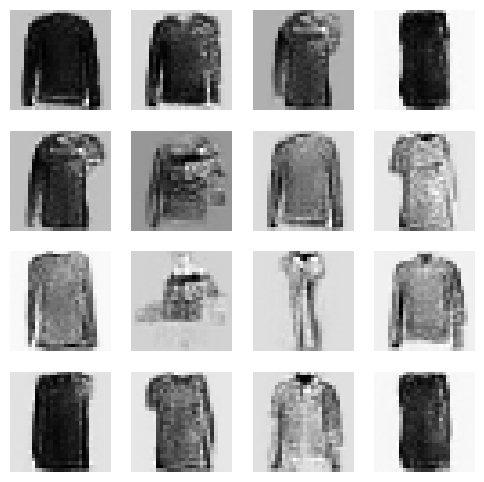

Época 95 de 1000
Pérdida del discriminador: 0.6252947449684143, Pérdida del generador: 2.290128707885742
Pérdida del discriminador: 0.6171045303344727, Pérdida del generador: 2.3001835346221924
Pérdida del discriminador: 0.5995397567749023, Pérdida del generador: 2.3258514404296875
Pérdida del discriminador: 0.6797902584075928, Pérdida del generador: 2.291720390319824
Pérdida del discriminador: 0.666361391544342, Pérdida del generador: 2.3805346488952637
Pérdida del discriminador: 0.6721525192260742, Pérdida del generador: 2.355900526046753
Pérdida del discriminador: 0.5975022315979004, Pérdida del generador: 2.3577280044555664
Pérdida del discriminador: 0.6379356980323792, Pérdida del generador: 2.3151259422302246
Pérdida del discriminador: 0.5811610221862793, Pérdida del generador: 2.291656017303467
Pérdida del discriminador: 0.561985969543457, Pérdida del generador: 2.2259340286254883
Pérdida del discriminador: 0.6242431402206421, Pérdida del generador: 2.2795372009277344
Pérdida de

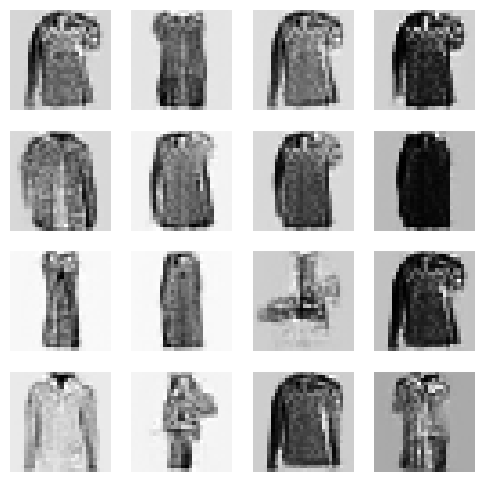

Época 97 de 1000
Pérdida del discriminador: 0.6913619041442871, Pérdida del generador: 2.2404696941375732
Pérdida del discriminador: 0.7049526572227478, Pérdida del generador: 2.4560883045196533
Pérdida del discriminador: 0.6887532472610474, Pérdida del generador: 2.450561285018921
Pérdida del discriminador: 0.740760087966919, Pérdida del generador: 2.2378034591674805
Pérdida del discriminador: 0.6674977540969849, Pérdida del generador: 2.236924648284912
Pérdida del discriminador: 0.6614216566085815, Pérdida del generador: 2.307669162750244
Pérdida del discriminador: 0.7090409994125366, Pérdida del generador: 2.3670763969421387
Pérdida del discriminador: 0.6210340261459351, Pérdida del generador: 2.426311492919922
Pérdida del discriminador: 0.7194947004318237, Pérdida del generador: 2.3974342346191406
Pérdida del discriminador: 0.6495472192764282, Pérdida del generador: 2.453549385070801
Pérdida del discriminador: 0.6821248531341553, Pérdida del generador: 2.1638123989105225
Pérdida de

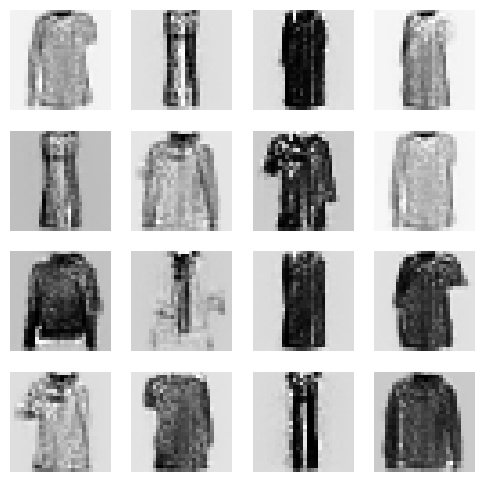

Época 99 de 1000
Pérdida del discriminador: 0.715800940990448, Pérdida del generador: 2.1877288818359375
Pérdida del discriminador: 0.6783332824707031, Pérdida del generador: 2.3321595191955566
Pérdida del discriminador: 0.8096598982810974, Pérdida del generador: 2.486372947692871
Pérdida del discriminador: 0.7752629518508911, Pérdida del generador: 2.4845244884490967
Pérdida del discriminador: 0.8317327499389648, Pérdida del generador: 2.186896562576294
Pérdida del discriminador: 0.7557123303413391, Pérdida del generador: 1.9588419198989868
Pérdida del discriminador: 0.741931676864624, Pérdida del generador: 2.001222610473633
Pérdida del discriminador: 0.8371643424034119, Pérdida del generador: 2.274578332901001
Pérdida del discriminador: 0.7355000972747803, Pérdida del generador: 2.5360467433929443
Pérdida del discriminador: 0.7871068120002747, Pérdida del generador: 2.621986150741577
Pérdida del discriminador: 0.7473425269126892, Pérdida del generador: 2.5830469131469727
Pérdida del

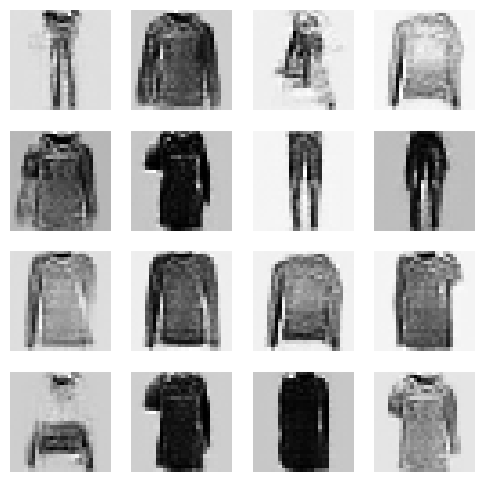

Época 101 de 1000
Pérdida del discriminador: 0.5952150821685791, Pérdida del generador: 2.1779847145080566
Pérdida del discriminador: 0.5553159117698669, Pérdida del generador: 2.196368455886841
Pérdida del discriminador: 0.6796356439590454, Pérdida del generador: 2.3224925994873047
Pérdida del discriminador: 0.6995662450790405, Pérdida del generador: 2.382943630218506
Pérdida del discriminador: 0.6542530059814453, Pérdida del generador: 2.237537145614624
Pérdida del discriminador: 0.6213452816009521, Pérdida del generador: 2.1641478538513184
Pérdida del discriminador: 0.7220653295516968, Pérdida del generador: 2.0398879051208496
Pérdida del discriminador: 0.708323061466217, Pérdida del generador: 1.9832327365875244
Pérdida del discriminador: 0.6263573169708252, Pérdida del generador: 2.1541943550109863
Pérdida del discriminador: 0.7012220025062561, Pérdida del generador: 2.2878212928771973
Pérdida del discriminador: 0.6864484548568726, Pérdida del generador: 2.4404284954071045
Pérdida

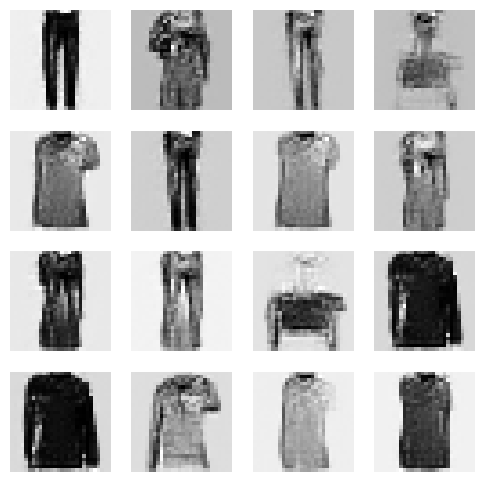

Época 103 de 1000
Pérdida del discriminador: 0.6709302067756653, Pérdida del generador: 2.31972336769104
Pérdida del discriminador: 0.6773335933685303, Pérdida del generador: 2.3640546798706055
Pérdida del discriminador: 0.7326574325561523, Pérdida del generador: 2.3412442207336426
Pérdida del discriminador: 0.666079044342041, Pérdida del generador: 2.1950583457946777
Pérdida del discriminador: 0.678739070892334, Pérdida del generador: 2.0901565551757812
Pérdida del discriminador: 0.7231916785240173, Pérdida del generador: 2.252683639526367
Pérdida del discriminador: 0.6053497791290283, Pérdida del generador: 2.3227756023406982
Pérdida del discriminador: 0.6809892654418945, Pérdida del generador: 2.4121036529541016
Pérdida del discriminador: 0.687604546546936, Pérdida del generador: 2.2179832458496094
Pérdida del discriminador: 0.648666262626648, Pérdida del generador: 2.185635566711426
Pérdida del discriminador: 0.6569535732269287, Pérdida del generador: 2.1967837810516357
Pérdida del

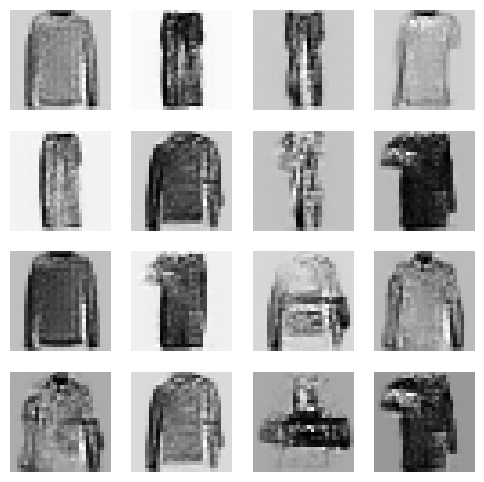

Época 105 de 1000
Pérdida del discriminador: 0.6531025767326355, Pérdida del generador: 2.4341864585876465
Pérdida del discriminador: 0.6665332317352295, Pérdida del generador: 2.4074692726135254
Pérdida del discriminador: 0.682569682598114, Pérdida del generador: 2.4359710216522217
Pérdida del discriminador: 0.752606987953186, Pérdida del generador: 2.3118228912353516
Pérdida del discriminador: 0.6613636612892151, Pérdida del generador: 2.19533109664917
Pérdida del discriminador: 0.6596211194992065, Pérdida del generador: 2.3399317264556885
Pérdida del discriminador: 0.6252903938293457, Pérdida del generador: 2.4708452224731445
Pérdida del discriminador: 0.8095673322677612, Pérdida del generador: 2.427069664001465
Pérdida del discriminador: 0.7210803031921387, Pérdida del generador: 2.2072834968566895
Pérdida del discriminador: 0.6813817024230957, Pérdida del generador: 2.249483108520508
Pérdida del discriminador: 0.6907248497009277, Pérdida del generador: 2.191643714904785
Pérdida de

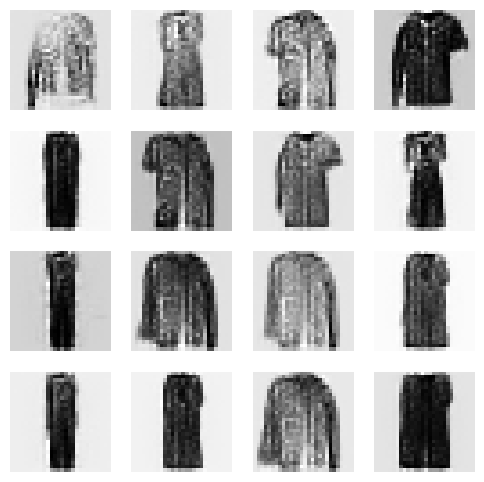

Época 107 de 1000
Pérdida del discriminador: 0.7332844138145447, Pérdida del generador: 2.5273146629333496
Pérdida del discriminador: 0.5486311912536621, Pérdida del generador: 2.449536085128784
Pérdida del discriminador: 0.6442614197731018, Pérdida del generador: 2.403775215148926
Pérdida del discriminador: 0.6488687992095947, Pérdida del generador: 2.299973964691162
Pérdida del discriminador: 0.6380744576454163, Pérdida del generador: 2.4159936904907227
Pérdida del discriminador: 0.5599435567855835, Pérdida del generador: 2.450579881668091
Pérdida del discriminador: 0.5469194054603577, Pérdida del generador: 2.6949071884155273
Pérdida del discriminador: 0.5684338808059692, Pérdida del generador: 2.9118740558624268
Pérdida del discriminador: 0.5510855913162231, Pérdida del generador: 2.7095460891723633
Pérdida del discriminador: 0.5671381950378418, Pérdida del generador: 2.435945510864258
Pérdida del discriminador: 0.4833680987358093, Pérdida del generador: 2.275017738342285
Pérdida d

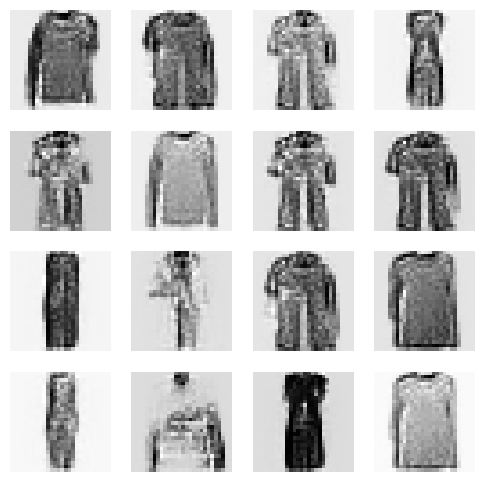

Época 109 de 1000
Pérdida del discriminador: 0.592424213886261, Pérdida del generador: 2.31223726272583
Pérdida del discriminador: 0.5952317714691162, Pérdida del generador: 2.5302319526672363
Pérdida del discriminador: 0.5955320596694946, Pérdida del generador: 2.6441426277160645
Pérdida del discriminador: 0.6728469133377075, Pérdida del generador: 2.54172945022583
Pérdida del discriminador: 0.6295149326324463, Pérdida del generador: 2.5985593795776367
Pérdida del discriminador: 0.6780803203582764, Pérdida del generador: 2.3620059490203857
Pérdida del discriminador: 0.6080507636070251, Pérdida del generador: 2.3267784118652344
Pérdida del discriminador: 0.6139512062072754, Pérdida del generador: 2.305474281311035
Pérdida del discriminador: 0.5989344716072083, Pérdida del generador: 2.3676462173461914
Pérdida del discriminador: 0.6199345588684082, Pérdida del generador: 2.414477586746216
Pérdida del discriminador: 0.6203410625457764, Pérdida del generador: 2.5046744346618652
Pérdida de

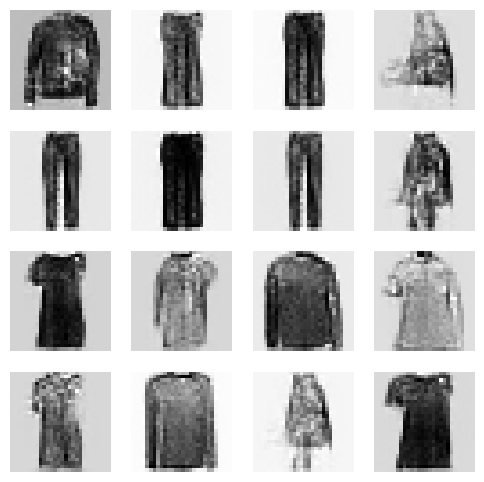

Época 111 de 1000
Pérdida del discriminador: 0.7047446966171265, Pérdida del generador: 2.2968406677246094
Pérdida del discriminador: 0.6164680123329163, Pérdida del generador: 2.123194932937622
Pérdida del discriminador: 0.5339362025260925, Pérdida del generador: 2.0773696899414062
Pérdida del discriminador: 0.6128891706466675, Pérdida del generador: 2.181760311126709
Pérdida del discriminador: 0.5928224325180054, Pérdida del generador: 2.319460868835449
Pérdida del discriminador: 0.678273618221283, Pérdida del generador: 2.4560048580169678
Pérdida del discriminador: 0.7542840242385864, Pérdida del generador: 2.4205408096313477
Pérdida del discriminador: 0.6486843228340149, Pérdida del generador: 2.3910071849823
Pérdida del discriminador: 0.6476578712463379, Pérdida del generador: 2.0881261825561523
Pérdida del discriminador: 0.6903590559959412, Pérdida del generador: 2.011890172958374
Pérdida del discriminador: 0.6648567914962769, Pérdida del generador: 2.1460933685302734
Pérdida del

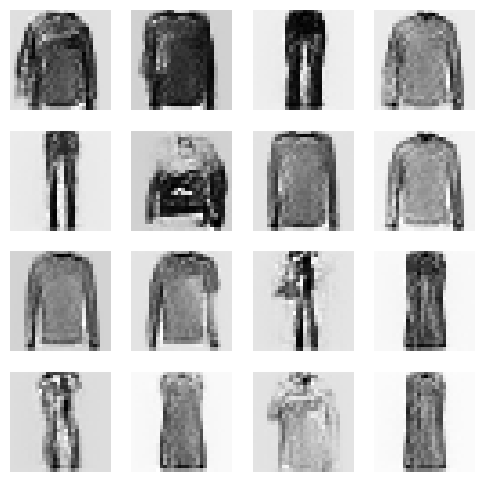

Época 113 de 1000
Pérdida del discriminador: 0.7459005117416382, Pérdida del generador: 2.419971466064453
Pérdida del discriminador: 0.6330850124359131, Pérdida del generador: 2.138378620147705
Pérdida del discriminador: 0.7331969738006592, Pérdida del generador: 1.9288909435272217
Pérdida del discriminador: 0.6858718395233154, Pérdida del generador: 1.9757764339447021
Pérdida del discriminador: 0.6907315850257874, Pérdida del generador: 2.388720989227295
Pérdida del discriminador: 0.6151070594787598, Pérdida del generador: 2.6789803504943848
Pérdida del discriminador: 0.7291910648345947, Pérdida del generador: 2.7263476848602295
Pérdida del discriminador: 0.6511052846908569, Pérdida del generador: 2.465186357498169
Pérdida del discriminador: 0.710877537727356, Pérdida del generador: 2.1400296688079834
Pérdida del discriminador: 0.6396620273590088, Pérdida del generador: 2.0660786628723145
Pérdida del discriminador: 0.7099084854125977, Pérdida del generador: 2.2071118354797363
Pérdida 

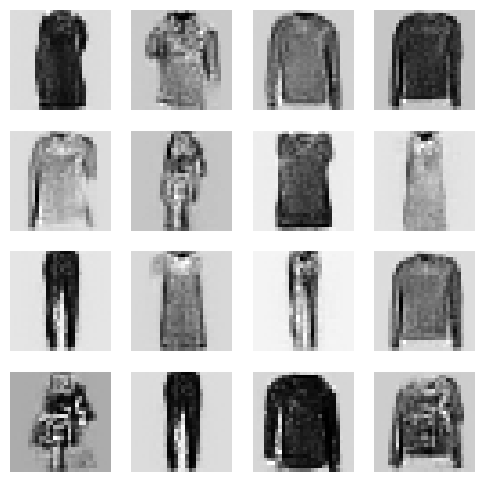

Época 115 de 1000
Pérdida del discriminador: 0.6644376516342163, Pérdida del generador: 2.2706284523010254
Pérdida del discriminador: 0.6193647980690002, Pérdida del generador: 2.205592155456543
Pérdida del discriminador: 0.689419686794281, Pérdida del generador: 2.3589534759521484
Pérdida del discriminador: 0.6715378761291504, Pérdida del generador: 2.4578373432159424
Pérdida del discriminador: 0.5795028209686279, Pérdida del generador: 2.49765944480896
Pérdida del discriminador: 0.669922947883606, Pérdida del generador: 2.4883861541748047
Pérdida del discriminador: 0.6562814712524414, Pérdida del generador: 2.301368474960327
Pérdida del discriminador: 0.6628884077072144, Pérdida del generador: 2.261303663253784
Pérdida del discriminador: 0.6295990943908691, Pérdida del generador: 2.3583741188049316
Pérdida del discriminador: 0.7287436127662659, Pérdida del generador: 2.2976675033569336
Pérdida del discriminador: 0.6385089755058289, Pérdida del generador: 2.4166698455810547
Pérdida de

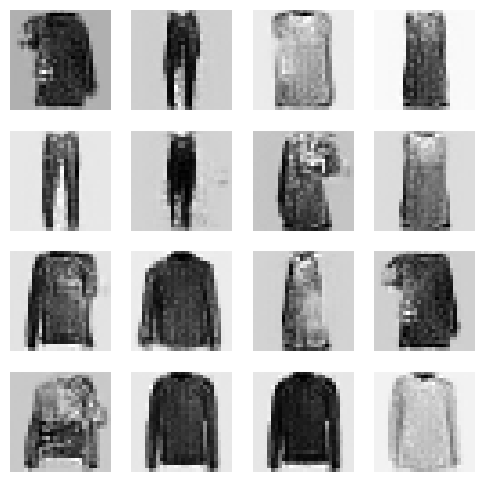

Época 117 de 1000
Pérdida del discriminador: 0.725326418876648, Pérdida del generador: 2.2140450477600098
Pérdida del discriminador: 0.6876689195632935, Pérdida del generador: 2.3767242431640625
Pérdida del discriminador: 0.7294855117797852, Pérdida del generador: 2.3456766605377197
Pérdida del discriminador: 0.7114903926849365, Pérdida del generador: 2.0824849605560303
Pérdida del discriminador: 0.6429349184036255, Pérdida del generador: 2.141761541366577
Pérdida del discriminador: 0.6072074770927429, Pérdida del generador: 2.2877748012542725
Pérdida del discriminador: 0.6552532911300659, Pérdida del generador: 2.3098690509796143
Pérdida del discriminador: 0.6817437410354614, Pérdida del generador: 2.216869354248047
Pérdida del discriminador: 0.6871864795684814, Pérdida del generador: 2.244795322418213
Pérdida del discriminador: 0.6466910243034363, Pérdida del generador: 2.305799961090088
Pérdida del discriminador: 0.7397755980491638, Pérdida del generador: 2.089686393737793
Pérdida d

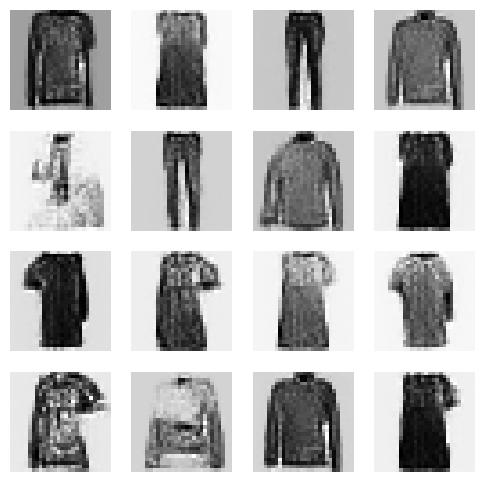

Época 119 de 1000
Pérdida del discriminador: 0.7036973237991333, Pérdida del generador: 2.0877270698547363
Pérdida del discriminador: 0.7179024815559387, Pérdida del generador: 2.098217487335205
Pérdida del discriminador: 0.7148489952087402, Pérdida del generador: 2.2526817321777344
Pérdida del discriminador: 0.7446959018707275, Pérdida del generador: 2.4282028675079346
Pérdida del discriminador: 0.7670004367828369, Pérdida del generador: 2.396152973175049
Pérdida del discriminador: 0.7398226857185364, Pérdida del generador: 2.2482125759124756
Pérdida del discriminador: 0.7343292236328125, Pérdida del generador: 2.1648061275482178
Pérdida del discriminador: 0.7388399839401245, Pérdida del generador: 2.021148204803467
Pérdida del discriminador: 0.7096537351608276, Pérdida del generador: 2.1469404697418213
Pérdida del discriminador: 0.7564783692359924, Pérdida del generador: 2.321765661239624
Pérdida del discriminador: 0.7205038666725159, Pérdida del generador: 2.4059925079345703
Pérdida

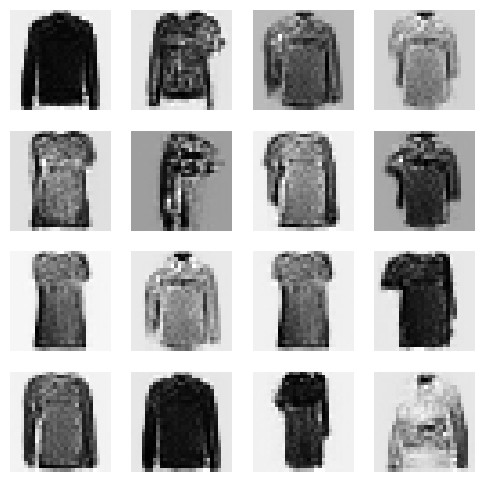

Época 121 de 1000
Pérdida del discriminador: 0.6919132471084595, Pérdida del generador: 2.0889623165130615
Pérdida del discriminador: 0.6461839079856873, Pérdida del generador: 2.2013707160949707
Pérdida del discriminador: 0.6873695850372314, Pérdida del generador: 2.352649688720703
Pérdida del discriminador: 0.7289121150970459, Pérdida del generador: 2.2857003211975098
Pérdida del discriminador: 0.6945782899856567, Pérdida del generador: 2.2739205360412598
Pérdida del discriminador: 0.6132169365882874, Pérdida del generador: 2.2324318885803223
Pérdida del discriminador: 0.6275414228439331, Pérdida del generador: 2.1369900703430176
Pérdida del discriminador: 0.6510583162307739, Pérdida del generador: 2.2213990688323975
Pérdida del discriminador: 0.6898736953735352, Pérdida del generador: 2.303375720977783
Pérdida del discriminador: 0.6931958198547363, Pérdida del generador: 2.3310632705688477
Pérdida del discriminador: 0.7030898332595825, Pérdida del generador: 2.25099778175354
Pérdida

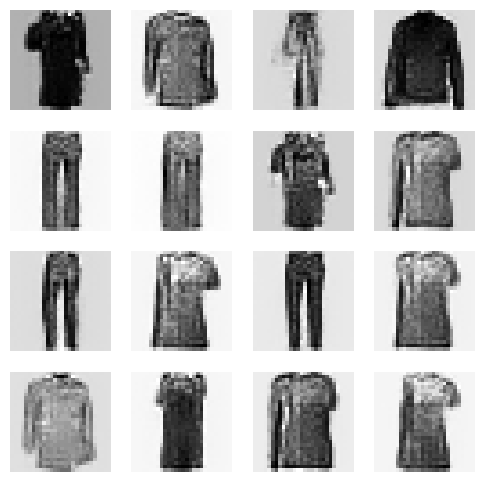

Época 123 de 1000
Pérdida del discriminador: 0.6186482906341553, Pérdida del generador: 2.1065163612365723
Pérdida del discriminador: 0.7116729021072388, Pérdida del generador: 2.125692844390869
Pérdida del discriminador: 0.6658072471618652, Pérdida del generador: 2.3441104888916016
Pérdida del discriminador: 0.6417950391769409, Pérdida del generador: 2.5994315147399902
Pérdida del discriminador: 0.6560698747634888, Pérdida del generador: 2.587568759918213
Pérdida del discriminador: 0.7084203958511353, Pérdida del generador: 2.3759448528289795
Pérdida del discriminador: 0.6223875284194946, Pérdida del generador: 2.2057814598083496
Pérdida del discriminador: 0.6888569593429565, Pérdida del generador: 2.0674376487731934
Pérdida del discriminador: 0.650793731212616, Pérdida del generador: 2.244872570037842
Pérdida del discriminador: 0.6682422757148743, Pérdida del generador: 2.433730125427246
Pérdida del discriminador: 0.7411980628967285, Pérdida del generador: 2.544023036956787
Pérdida d

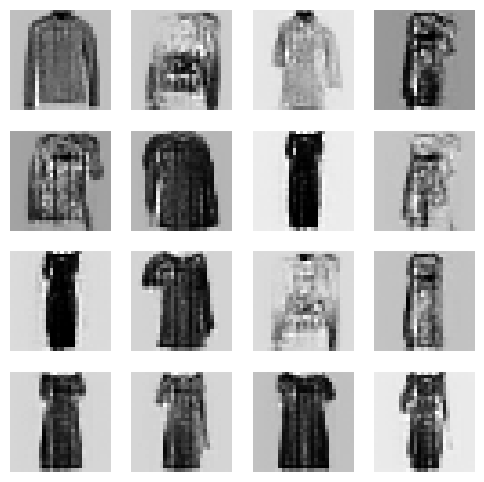

Época 125 de 1000
Pérdida del discriminador: 0.7427089214324951, Pérdida del generador: 2.4858717918395996
Pérdida del discriminador: 0.613251268863678, Pérdida del generador: 2.415379285812378
Pérdida del discriminador: 0.6469906568527222, Pérdida del generador: 2.519895553588867
Pérdida del discriminador: 0.5887210369110107, Pérdida del generador: 2.610755443572998
Pérdida del discriminador: 0.6121069192886353, Pérdida del generador: 2.731658458709717
Pérdida del discriminador: 0.5934625864028931, Pérdida del generador: 2.859996795654297
Pérdida del discriminador: 0.5701500177383423, Pérdida del generador: 2.840275526046753
Pérdida del discriminador: 0.5865563154220581, Pérdida del generador: 2.7397947311401367
Pérdida del discriminador: 0.6736865639686584, Pérdida del generador: 2.594996929168701
Pérdida del discriminador: 0.5719776153564453, Pérdida del generador: 2.6040449142456055
Pérdida del discriminador: 0.5369988679885864, Pérdida del generador: 2.817448854446411
Pérdida del 

2025-02-11 22:04:44.583806: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


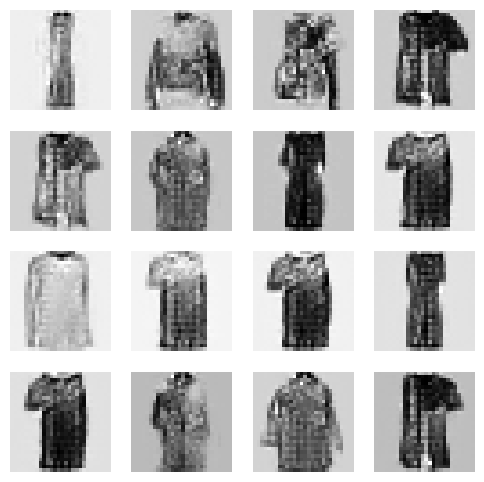

Época 127 de 1000
Pérdida del discriminador: 0.6156207323074341, Pérdida del generador: 2.8803839683532715
Pérdida del discriminador: 0.687944769859314, Pérdida del generador: 2.7385635375976562
Pérdida del discriminador: 0.5344701409339905, Pérdida del generador: 2.6999950408935547
Pérdida del discriminador: 0.5558242201805115, Pérdida del generador: 2.6915810108184814
Pérdida del discriminador: 0.5807908773422241, Pérdida del generador: 2.52001690864563
Pérdida del discriminador: 0.5313536524772644, Pérdida del generador: 2.648876905441284
Pérdida del discriminador: 0.5634444952011108, Pérdida del generador: 2.6508708000183105
Pérdida del discriminador: 0.5968667268753052, Pérdida del generador: 2.7143564224243164
Pérdida del discriminador: 0.5553399324417114, Pérdida del generador: 3.0565738677978516
Pérdida del discriminador: 0.5392778515815735, Pérdida del generador: 2.8836681842803955
Pérdida del discriminador: 0.6024088263511658, Pérdida del generador: 2.650010585784912
Pérdida 

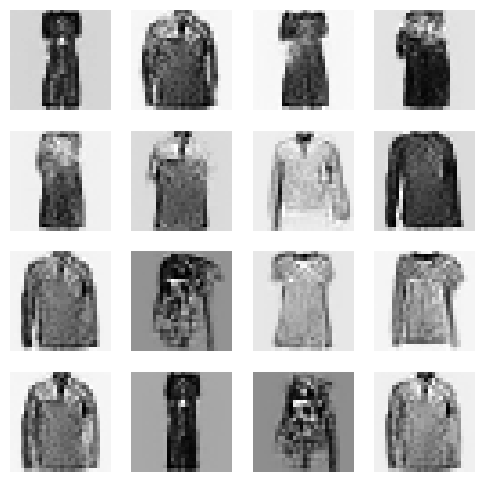

Época 129 de 1000
Pérdida del discriminador: 0.6293145418167114, Pérdida del generador: 2.428750514984131
Pérdida del discriminador: 0.6711885333061218, Pérdida del generador: 2.5071585178375244
Pérdida del discriminador: 0.5907791256904602, Pérdida del generador: 2.6155076026916504
Pérdida del discriminador: 0.5939909815788269, Pérdida del generador: 2.608863353729248
Pérdida del discriminador: 0.6073646545410156, Pérdida del generador: 2.597390651702881
Pérdida del discriminador: 0.69037926197052, Pérdida del generador: 2.4993069171905518
Pérdida del discriminador: 0.6067992448806763, Pérdida del generador: 2.3991589546203613
Pérdida del discriminador: 0.6391220092773438, Pérdida del generador: 2.6025729179382324
Pérdida del discriminador: 0.6622663736343384, Pérdida del generador: 2.602220058441162
Pérdida del discriminador: 0.5670572519302368, Pérdida del generador: 2.535855293273926
Pérdida del discriminador: 0.6071740984916687, Pérdida del generador: 2.5588607788085938
Pérdida de

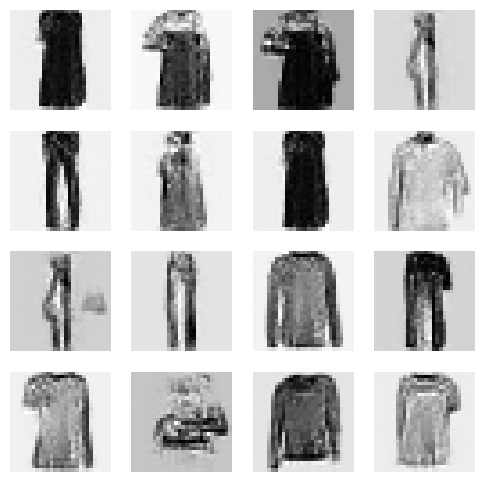

Época 131 de 1000
Pérdida del discriminador: 0.6717392206192017, Pérdida del generador: 2.2842893600463867
Pérdida del discriminador: 0.6963478326797485, Pérdida del generador: 2.214653968811035
Pérdida del discriminador: 0.5842427015304565, Pérdida del generador: 2.3824920654296875
Pérdida del discriminador: 0.5818783640861511, Pérdida del generador: 2.544182777404785
Pérdida del discriminador: 0.6138232350349426, Pérdida del generador: 2.6942763328552246
Pérdida del discriminador: 0.588057279586792, Pérdida del generador: 2.669358491897583
Pérdida del discriminador: 0.618772566318512, Pérdida del generador: 2.3571438789367676
Pérdida del discriminador: 0.6757254004478455, Pérdida del generador: 2.3431005477905273
Pérdida del discriminador: 0.5964435338973999, Pérdida del generador: 2.2644307613372803
Pérdida del discriminador: 0.6280077695846558, Pérdida del generador: 2.3632469177246094
Pérdida del discriminador: 0.7076189517974854, Pérdida del generador: 2.4597599506378174
Pérdida 

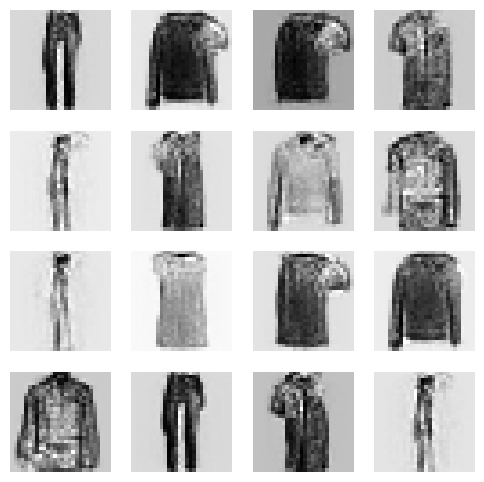

Época 133 de 1000
Pérdida del discriminador: 0.6593125462532043, Pérdida del generador: 2.120624542236328
Pérdida del discriminador: 0.7143161296844482, Pérdida del generador: 2.2354931831359863
Pérdida del discriminador: 0.7230516672134399, Pérdida del generador: 2.3736164569854736
Pérdida del discriminador: 0.6286274790763855, Pérdida del generador: 2.6370468139648438
Pérdida del discriminador: 0.7078716158866882, Pérdida del generador: 2.598665237426758
Pérdida del discriminador: 0.6526411771774292, Pérdida del generador: 2.612731695175171
Pérdida del discriminador: 0.5733208656311035, Pérdida del generador: 2.426241397857666
Pérdida del discriminador: 0.7663334608078003, Pérdida del generador: 2.416466474533081
Pérdida del discriminador: 0.8320666551589966, Pérdida del generador: 2.283130645751953
Pérdida del discriminador: 0.6463565826416016, Pérdida del generador: 2.32422137260437
Pérdida del discriminador: 0.6417320370674133, Pérdida del generador: 2.6429708003997803
Pérdida del

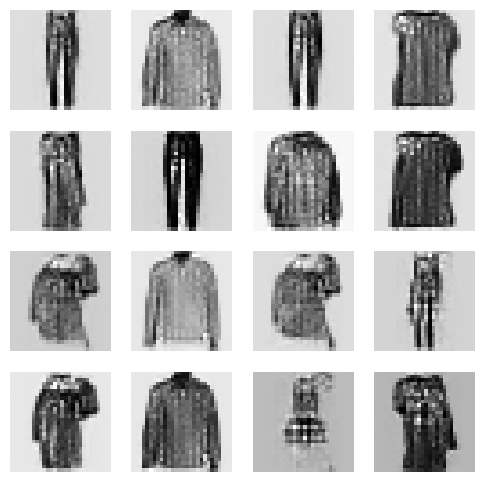

Época 135 de 1000
Pérdida del discriminador: 0.8107509613037109, Pérdida del generador: 2.215458869934082
Pérdida del discriminador: 0.7603026032447815, Pérdida del generador: 2.361186981201172
Pérdida del discriminador: 0.7447377443313599, Pérdida del generador: 2.493748188018799
Pérdida del discriminador: 0.8358555436134338, Pérdida del generador: 2.4654502868652344
Pérdida del discriminador: 0.7544859051704407, Pérdida del generador: 2.3983092308044434
Pérdida del discriminador: 0.8717966675758362, Pérdida del generador: 2.3399438858032227
Pérdida del discriminador: 0.5953511595726013, Pérdida del generador: 2.4272584915161133
Pérdida del discriminador: 0.7502039074897766, Pérdida del generador: 2.485895872116089
Pérdida del discriminador: 0.6834254264831543, Pérdida del generador: 2.5381522178649902
Pérdida del discriminador: 0.6861879229545593, Pérdida del generador: 2.6181063652038574
Pérdida del discriminador: 0.6432706713676453, Pérdida del generador: 2.6383726596832275
Pérdida

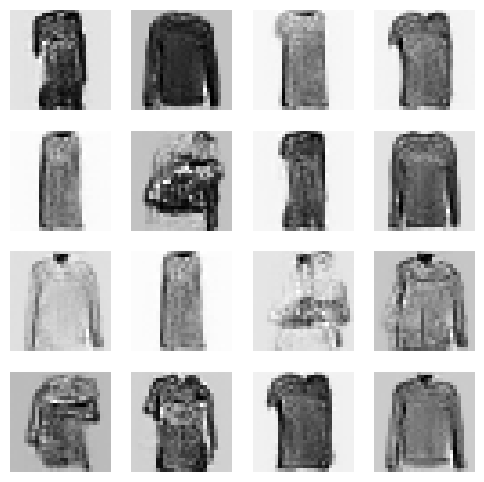

Época 137 de 1000
Pérdida del discriminador: 0.6648356914520264, Pérdida del generador: 2.2063446044921875
Pérdida del discriminador: 0.6945276856422424, Pérdida del generador: 2.434119939804077
Pérdida del discriminador: 0.5812619924545288, Pérdida del generador: 2.6410717964172363
Pérdida del discriminador: 0.6409699320793152, Pérdida del generador: 2.784726142883301
Pérdida del discriminador: 0.6093763113021851, Pérdida del generador: 2.7733993530273438
Pérdida del discriminador: 0.6505102515220642, Pérdida del generador: 2.561234474182129
Pérdida del discriminador: 0.6324371695518494, Pérdida del generador: 2.362325668334961
Pérdida del discriminador: 0.7046763896942139, Pérdida del generador: 2.204387664794922
Pérdida del discriminador: 0.618879497051239, Pérdida del generador: 2.2107176780700684
Pérdida del discriminador: 0.6663349270820618, Pérdida del generador: 2.3987464904785156
Pérdida del discriminador: 0.6675726175308228, Pérdida del generador: 2.5779552459716797
Pérdida d

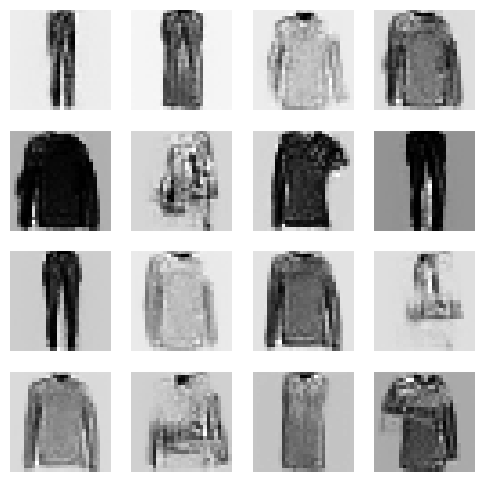

Época 139 de 1000
Pérdida del discriminador: 0.6546684503555298, Pérdida del generador: 2.7290396690368652
Pérdida del discriminador: 0.6917982697486877, Pérdida del generador: 2.365445613861084
Pérdida del discriminador: 0.6533702611923218, Pérdida del generador: 2.203209400177002
Pérdida del discriminador: 0.6792683601379395, Pérdida del generador: 2.248690605163574
Pérdida del discriminador: 0.7173537015914917, Pérdida del generador: 2.4632492065429688
Pérdida del discriminador: 0.6042830944061279, Pérdida del generador: 2.792163372039795
Pérdida del discriminador: 0.6729655265808105, Pérdida del generador: 2.8197073936462402
Pérdida del discriminador: 0.5102906227111816, Pérdida del generador: 2.6598153114318848
Pérdida del discriminador: 0.5585280060768127, Pérdida del generador: 2.4651691913604736
Pérdida del discriminador: 0.6376712322235107, Pérdida del generador: 2.2469987869262695
Pérdida del discriminador: 0.692061722278595, Pérdida del generador: 2.330875873565674
Pérdida d

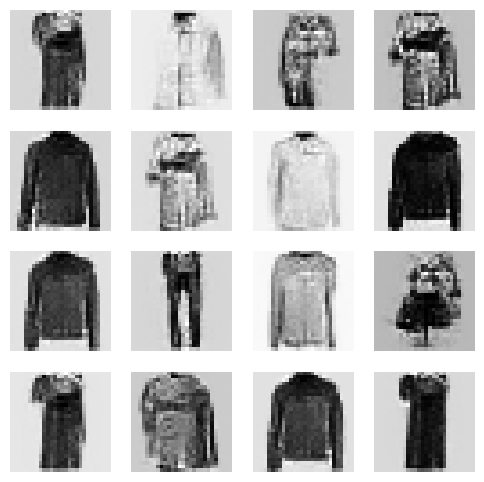

Época 141 de 1000
Pérdida del discriminador: 0.7262388467788696, Pérdida del generador: 2.4092025756835938
Pérdida del discriminador: 0.738703727722168, Pérdida del generador: 2.186546802520752
Pérdida del discriminador: 0.6541016101837158, Pérdida del generador: 2.2669105529785156
Pérdida del discriminador: 0.7351182103157043, Pérdida del generador: 2.342999219894409
Pérdida del discriminador: 0.5684288740158081, Pérdida del generador: 2.5460190773010254
Pérdida del discriminador: 0.6527693867683411, Pérdida del generador: 2.4302186965942383
Pérdida del discriminador: 0.6487026810646057, Pérdida del generador: 2.1862382888793945
Pérdida del discriminador: 0.6741254329681396, Pérdida del generador: 2.058743715286255
Pérdida del discriminador: 0.6704659461975098, Pérdida del generador: 2.101292133331299
Pérdida del discriminador: 0.7232170104980469, Pérdida del generador: 2.347701072692871
Pérdida del discriminador: 0.6355702877044678, Pérdida del generador: 2.5345065593719482
Pérdida d

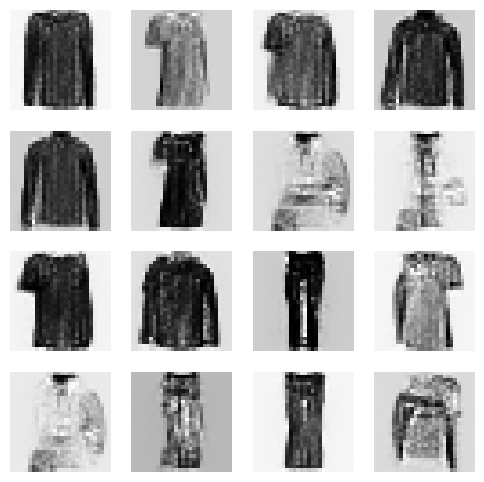

Época 143 de 1000
Pérdida del discriminador: 0.6082379817962646, Pérdida del generador: 2.2324790954589844
Pérdida del discriminador: 0.6685364246368408, Pérdida del generador: 2.4008448123931885
Pérdida del discriminador: 0.6647177338600159, Pérdida del generador: 2.700664758682251
Pérdida del discriminador: 0.6658468246459961, Pérdida del generador: 2.7521817684173584
Pérdida del discriminador: 0.5739542245864868, Pérdida del generador: 2.6328165531158447
Pérdida del discriminador: 0.7851195931434631, Pérdida del generador: 2.2373671531677246
Pérdida del discriminador: 0.6354694962501526, Pérdida del generador: 2.0897984504699707
Pérdida del discriminador: 0.6730462312698364, Pérdida del generador: 2.07436466217041
Pérdida del discriminador: 0.7205162644386292, Pérdida del generador: 2.4413180351257324
Pérdida del discriminador: 0.7034473419189453, Pérdida del generador: 2.5750107765197754
Pérdida del discriminador: 0.6914921998977661, Pérdida del generador: 2.7890536785125732
Pérdid

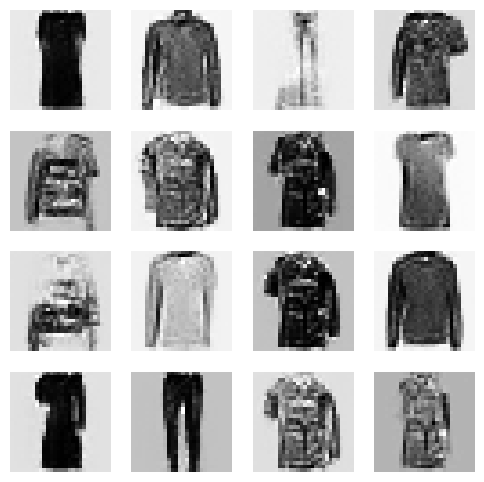

Época 145 de 1000
Pérdida del discriminador: 0.7832576036453247, Pérdida del generador: 2.5607428550720215
Pérdida del discriminador: 0.6637205481529236, Pérdida del generador: 2.6057496070861816
Pérdida del discriminador: 0.6490774750709534, Pérdida del generador: 2.3466358184814453
Pérdida del discriminador: 0.71343994140625, Pérdida del generador: 2.2048866748809814
Pérdida del discriminador: 0.7716041803359985, Pérdida del generador: 2.1337010860443115
Pérdida del discriminador: 0.6276128888130188, Pérdida del generador: 2.3291265964508057
Pérdida del discriminador: 0.7009623050689697, Pérdida del generador: 2.46683669090271
Pérdida del discriminador: 0.6941527128219604, Pérdida del generador: 2.550760269165039
Pérdida del discriminador: 0.6575654745101929, Pérdida del generador: 2.541698455810547
Pérdida del discriminador: 0.6821317672729492, Pérdida del generador: 2.493448257446289
Pérdida del discriminador: 0.6808501482009888, Pérdida del generador: 2.487321615219116
Pérdida del

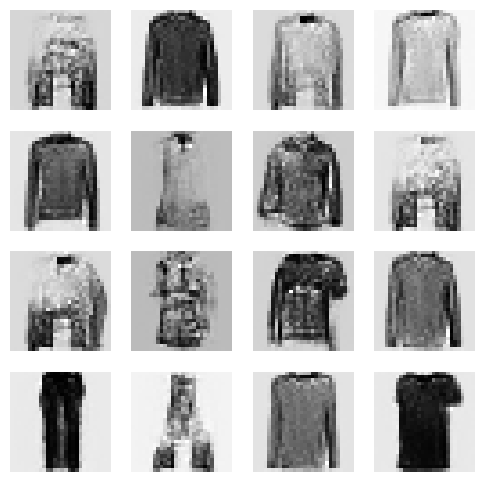

Época 147 de 1000
Pérdida del discriminador: 0.688370943069458, Pérdida del generador: 2.4744057655334473
Pérdida del discriminador: 0.7078014612197876, Pérdida del generador: 2.228411912918091
Pérdida del discriminador: 0.648990273475647, Pérdida del generador: 2.2776856422424316
Pérdida del discriminador: 0.7796332836151123, Pérdida del generador: 2.4536709785461426
Pérdida del discriminador: 0.7286955714225769, Pérdida del generador: 2.4677529335021973
Pérdida del discriminador: 0.6140124797821045, Pérdida del generador: 2.6557817459106445
Pérdida del discriminador: 0.6807180643081665, Pérdida del generador: 2.6633968353271484
Pérdida del discriminador: 0.6458034515380859, Pérdida del generador: 2.535223960876465
Pérdida del discriminador: 0.6861735582351685, Pérdida del generador: 2.4599757194519043
Pérdida del discriminador: 0.6390366554260254, Pérdida del generador: 2.5060477256774902
Pérdida del discriminador: 0.7854534983634949, Pérdida del generador: 2.3217411041259766
Pérdida

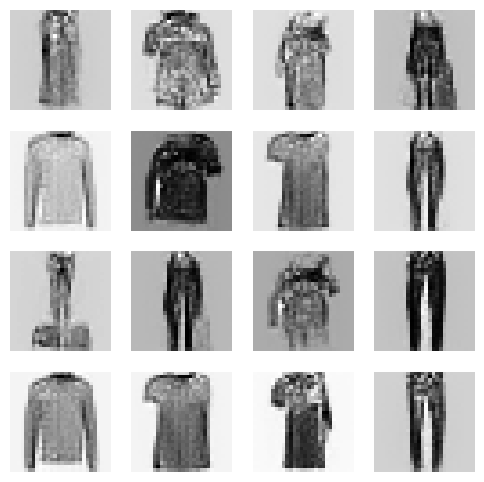

Época 149 de 1000
Pérdida del discriminador: 0.6094439029693604, Pérdida del generador: 2.6263771057128906
Pérdida del discriminador: 0.6305701732635498, Pérdida del generador: 2.8777010440826416
Pérdida del discriminador: 0.6348875761032104, Pérdida del generador: 2.866522789001465
Pérdida del discriminador: 0.6326903700828552, Pérdida del generador: 2.646305799484253
Pérdida del discriminador: 0.6168455481529236, Pérdida del generador: 2.4955945014953613
Pérdida del discriminador: 0.659142255783081, Pérdida del generador: 2.3537797927856445
Pérdida del discriminador: 0.58977210521698, Pérdida del generador: 2.4173974990844727
Pérdida del discriminador: 0.6350488066673279, Pérdida del generador: 2.4873111248016357
Pérdida del discriminador: 0.6142295598983765, Pérdida del generador: 2.699186325073242
Pérdida del discriminador: 0.6752979159355164, Pérdida del generador: 2.722731351852417
Pérdida del discriminador: 0.6527358889579773, Pérdida del generador: 2.6031723022460938
Pérdida de

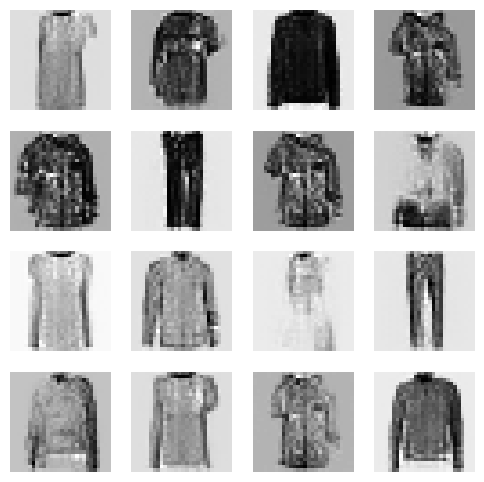

Época 151 de 1000
Pérdida del discriminador: 0.6502033472061157, Pérdida del generador: 2.3730056285858154
Pérdida del discriminador: 0.6801449060440063, Pérdida del generador: 2.3679709434509277
Pérdida del discriminador: 0.6969144940376282, Pérdida del generador: 2.3008272647857666
Pérdida del discriminador: 0.747982919216156, Pérdida del generador: 2.3475708961486816
Pérdida del discriminador: 0.6931127309799194, Pérdida del generador: 2.34419846534729
Pérdida del discriminador: 0.66960209608078, Pérdida del generador: 2.362370491027832
Pérdida del discriminador: 0.6895079016685486, Pérdida del generador: 2.469393014907837
Pérdida del discriminador: 0.7584763765335083, Pérdida del generador: 2.3475379943847656
Pérdida del discriminador: 0.7874253988265991, Pérdida del generador: 2.3611717224121094
Pérdida del discriminador: 0.7229123711585999, Pérdida del generador: 2.4650635719299316
Pérdida del discriminador: 0.7384926080703735, Pérdida del generador: 2.3686633110046387
Pérdida de

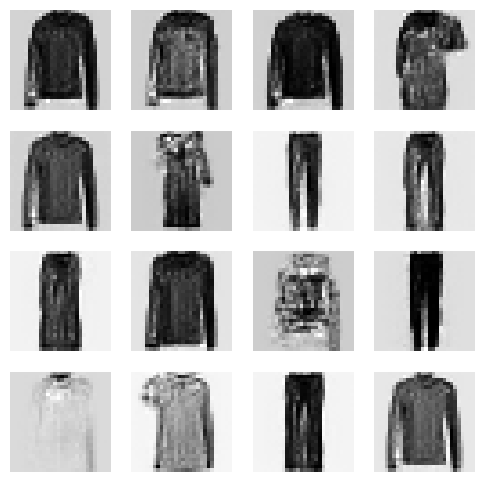

Época 153 de 1000
Pérdida del discriminador: 0.6003856658935547, Pérdida del generador: 2.621142864227295
Pérdida del discriminador: 0.626681923866272, Pérdida del generador: 2.560145854949951
Pérdida del discriminador: 0.6125378608703613, Pérdida del generador: 2.486891746520996
Pérdida del discriminador: 0.5795741081237793, Pérdida del generador: 2.6106064319610596
Pérdida del discriminador: 0.5922657251358032, Pérdida del generador: 2.6884777545928955
Pérdida del discriminador: 0.6184048652648926, Pérdida del generador: 2.6864113807678223
Pérdida del discriminador: 0.6316424608230591, Pérdida del generador: 2.5889034271240234
Pérdida del discriminador: 0.5884376764297485, Pérdida del generador: 2.5130538940429688
Pérdida del discriminador: 0.6232705116271973, Pérdida del generador: 2.427116870880127
Pérdida del discriminador: 0.5815944075584412, Pérdida del generador: 2.5082778930664062
Pérdida del discriminador: 0.6451555490493774, Pérdida del generador: 2.652634859085083
Pérdida d

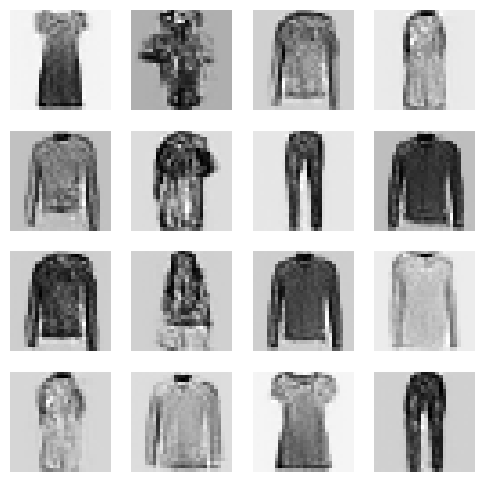

Época 155 de 1000
Pérdida del discriminador: 0.7591471672058105, Pérdida del generador: 2.5889062881469727
Pérdida del discriminador: 0.7394468784332275, Pérdida del generador: 2.354830265045166
Pérdida del discriminador: 0.6728557348251343, Pérdida del generador: 2.138584613800049
Pérdida del discriminador: 0.7294526100158691, Pérdida del generador: 2.3960824012756348
Pérdida del discriminador: 0.7073140144348145, Pérdida del generador: 2.5744128227233887
Pérdida del discriminador: 0.7050271034240723, Pérdida del generador: 2.6249160766601562
Pérdida del discriminador: 0.6767215728759766, Pérdida del generador: 2.649019241333008
Pérdida del discriminador: 0.7028629183769226, Pérdida del generador: 2.654991626739502
Pérdida del discriminador: 0.7189256548881531, Pérdida del generador: 2.4700064659118652
Pérdida del discriminador: 0.6817752718925476, Pérdida del generador: 2.4443564414978027
Pérdida del discriminador: 0.5894705057144165, Pérdida del generador: 2.5389723777770996
Pérdida

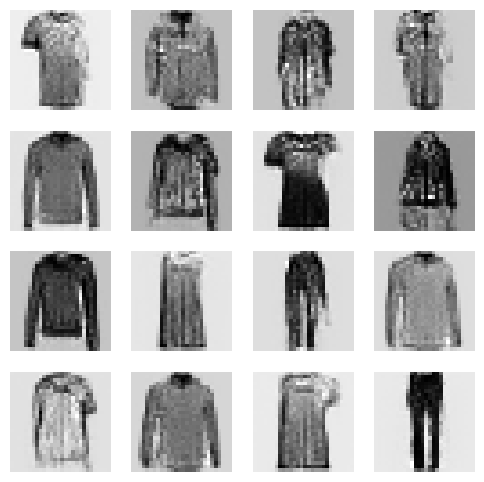

Época 157 de 1000
Pérdida del discriminador: 0.745183527469635, Pérdida del generador: 2.4031903743743896
Pérdida del discriminador: 0.7470639944076538, Pérdida del generador: 2.4493608474731445
Pérdida del discriminador: 0.6575129628181458, Pérdida del generador: 2.4142961502075195
Pérdida del discriminador: 0.6831445693969727, Pérdida del generador: 2.4140071868896484
Pérdida del discriminador: 0.6700762510299683, Pérdida del generador: 2.551103353500366
Pérdida del discriminador: 0.644447922706604, Pérdida del generador: 2.7039361000061035
Pérdida del discriminador: 0.6478517651557922, Pérdida del generador: 2.7080137729644775
Pérdida del discriminador: 0.6952205300331116, Pérdida del generador: 2.4622714519500732
Pérdida del discriminador: 0.6917122602462769, Pérdida del generador: 2.3569211959838867
Pérdida del discriminador: 0.7606565952301025, Pérdida del generador: 2.1427249908447266
Pérdida del discriminador: 0.6788198947906494, Pérdida del generador: 2.161038398742676
Pérdida

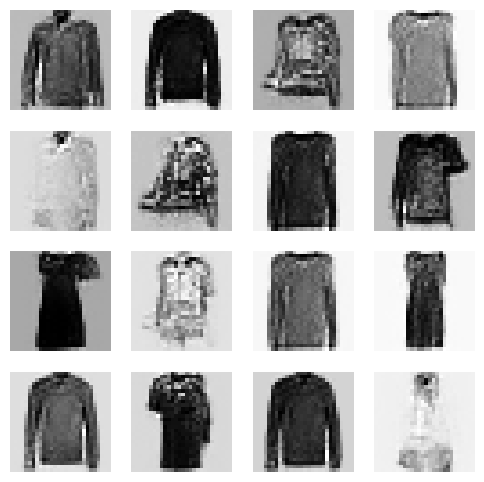

Época 159 de 1000
Pérdida del discriminador: 0.6842018365859985, Pérdida del generador: 2.408111810684204
Pérdida del discriminador: 0.6493195295333862, Pérdida del generador: 2.5810227394104004
Pérdida del discriminador: 0.633338212966919, Pérdida del generador: 2.6610491275787354
Pérdida del discriminador: 0.6787399053573608, Pérdida del generador: 2.4750523567199707
Pérdida del discriminador: 0.7113568186759949, Pérdida del generador: 2.3047587871551514
Pérdida del discriminador: 0.7051944136619568, Pérdida del generador: 2.3327107429504395
Pérdida del discriminador: 0.7305498123168945, Pérdida del generador: 2.488582134246826
Pérdida del discriminador: 0.6181094646453857, Pérdida del generador: 2.6568713188171387
Pérdida del discriminador: 0.7077656984329224, Pérdida del generador: 2.7653465270996094
Pérdida del discriminador: 0.6534967422485352, Pérdida del generador: 2.5278310775756836
Pérdida del discriminador: 0.6383466720581055, Pérdida del generador: 2.267948627471924
Pérdida

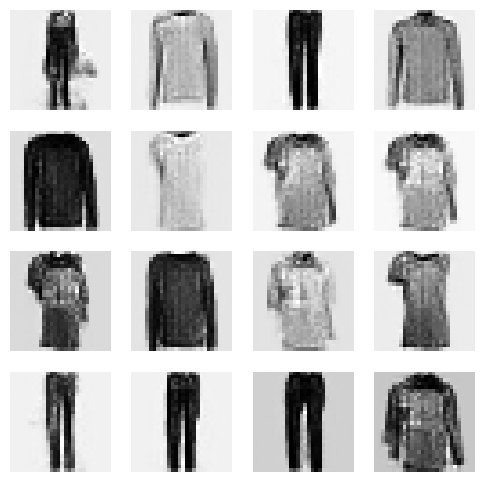

Época 161 de 1000
Pérdida del discriminador: 0.6932427883148193, Pérdida del generador: 2.357485055923462
Pérdida del discriminador: 0.6479618549346924, Pérdida del generador: 2.6239750385284424
Pérdida del discriminador: 0.7196839451789856, Pérdida del generador: 2.523782730102539
Pérdida del discriminador: 0.7153167724609375, Pérdida del generador: 2.4600582122802734
Pérdida del discriminador: 0.7110192179679871, Pérdida del generador: 2.377840042114258
Pérdida del discriminador: 0.6106598377227783, Pérdida del generador: 2.3775999546051025
Pérdida del discriminador: 0.6913697123527527, Pérdida del generador: 2.3635001182556152
Pérdida del discriminador: 0.7812325358390808, Pérdida del generador: 2.3411989212036133
Pérdida del discriminador: 0.7386327981948853, Pérdida del generador: 2.358429193496704
Pérdida del discriminador: 0.6507863998413086, Pérdida del generador: 2.438201427459717
Pérdida del discriminador: 0.6917738914489746, Pérdida del generador: 2.5591630935668945
Pérdida 

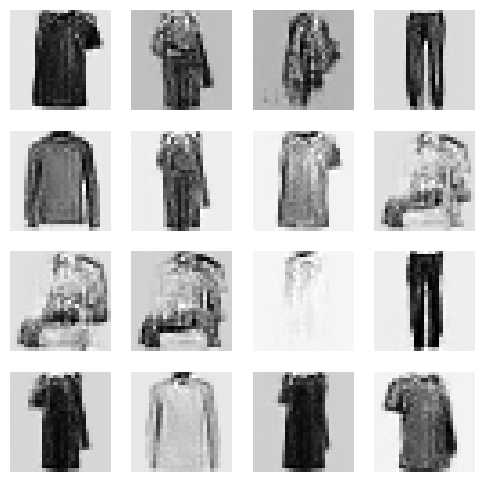

Época 163 de 1000
Pérdida del discriminador: 0.6976948976516724, Pérdida del generador: 2.3964476585388184
Pérdida del discriminador: 0.7939555644989014, Pérdida del generador: 2.538665771484375
Pérdida del discriminador: 0.7773995399475098, Pérdida del generador: 2.4991567134857178
Pérdida del discriminador: 0.6845206618309021, Pérdida del generador: 2.4153859615325928
Pérdida del discriminador: 0.7539994716644287, Pérdida del generador: 2.2468791007995605
Pérdida del discriminador: 0.652341902256012, Pérdida del generador: 2.2727322578430176
Pérdida del discriminador: 0.6971211433410645, Pérdida del generador: 2.411238193511963
Pérdida del discriminador: 0.6693742871284485, Pérdida del generador: 2.416656494140625
Pérdida del discriminador: 0.7416425943374634, Pérdida del generador: 2.5187811851501465
Pérdida del discriminador: 0.7145498991012573, Pérdida del generador: 2.4887731075286865
Pérdida del discriminador: 0.7361015677452087, Pérdida del generador: 2.248945713043213
Pérdida 

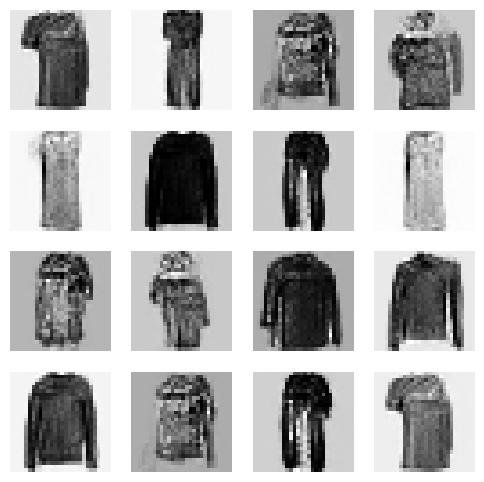

Época 165 de 1000
Pérdida del discriminador: 0.7392853498458862, Pérdida del generador: 2.485018730163574
Pérdida del discriminador: 0.7705865502357483, Pérdida del generador: 2.111471176147461
Pérdida del discriminador: 0.71748948097229, Pérdida del generador: 2.128878355026245
Pérdida del discriminador: 0.7233723402023315, Pérdida del generador: 2.416642665863037
Pérdida del discriminador: 0.6734656691551208, Pérdida del generador: 2.8351311683654785
Pérdida del discriminador: 0.7980024814605713, Pérdida del generador: 2.9010095596313477
Pérdida del discriminador: 0.6650768518447876, Pérdida del generador: 2.771850109100342
Pérdida del discriminador: 0.7564759254455566, Pérdida del generador: 2.4834368228912354
Pérdida del discriminador: 0.7214317917823792, Pérdida del generador: 2.201901912689209
Pérdida del discriminador: 0.7057555913925171, Pérdida del generador: 2.0047426223754883
Pérdida del discriminador: 0.7935733199119568, Pérdida del generador: 2.2270593643188477
Pérdida del

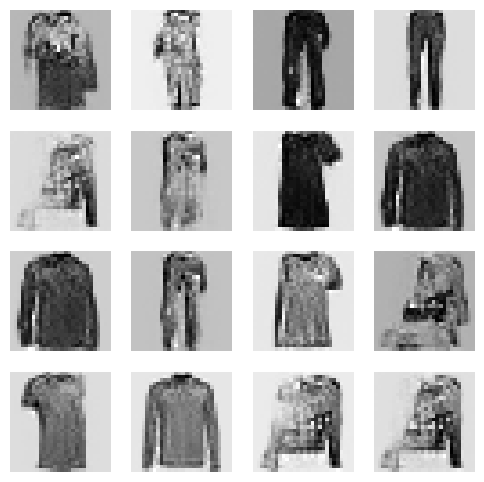

Época 167 de 1000
Pérdida del discriminador: 0.6094763278961182, Pérdida del generador: 2.5839128494262695
Pérdida del discriminador: 0.6302372813224792, Pérdida del generador: 2.8435959815979004
Pérdida del discriminador: 0.696532130241394, Pérdida del generador: 2.8392343521118164
Pérdida del discriminador: 0.6413828134536743, Pérdida del generador: 2.6247518062591553
Pérdida del discriminador: 0.6594936847686768, Pérdida del generador: 2.5582427978515625
Pérdida del discriminador: 0.7155603766441345, Pérdida del generador: 2.3322949409484863
Pérdida del discriminador: 0.6888762712478638, Pérdida del generador: 2.3574461936950684
Pérdida del discriminador: 0.6643264293670654, Pérdida del generador: 2.545370578765869
Pérdida del discriminador: 0.6266330480575562, Pérdida del generador: 2.7192635536193848
Pérdida del discriminador: 0.6893495321273804, Pérdida del generador: 2.656078338623047
Pérdida del discriminador: 0.7605075836181641, Pérdida del generador: 2.413663625717163
Pérdida

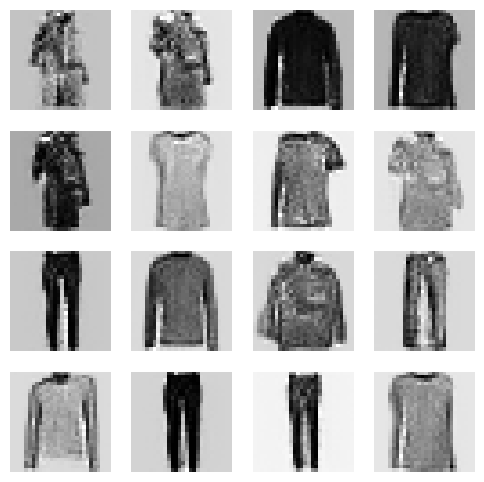

Época 169 de 1000
Pérdida del discriminador: 0.7316784262657166, Pérdida del generador: 2.597773551940918
Pérdida del discriminador: 0.6349034309387207, Pérdida del generador: 2.421588897705078
Pérdida del discriminador: 0.6741565465927124, Pérdida del generador: 2.295219659805298
Pérdida del discriminador: 0.6722574234008789, Pérdida del generador: 2.4628450870513916
Pérdida del discriminador: 0.6639725565910339, Pérdida del generador: 2.367502212524414
Pérdida del discriminador: 0.6831918954849243, Pérdida del generador: 2.546872138977051
Pérdida del discriminador: 0.6972112655639648, Pérdida del generador: 2.4903125762939453
Pérdida del discriminador: 0.7176285982131958, Pérdida del generador: 2.337653636932373
Pérdida del discriminador: 0.7696832418441772, Pérdida del generador: 2.3371214866638184
Pérdida del discriminador: 0.7348099946975708, Pérdida del generador: 2.5197012424468994
Pérdida del discriminador: 0.7711055278778076, Pérdida del generador: 2.418674945831299
Pérdida de

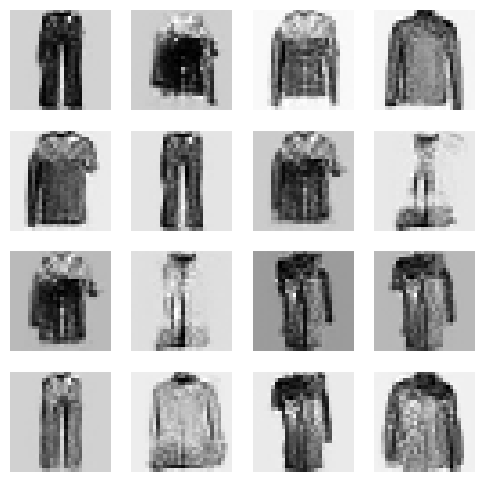

Época 171 de 1000
Pérdida del discriminador: 0.6229100227355957, Pérdida del generador: 2.291275978088379
Pérdida del discriminador: 0.694270133972168, Pérdida del generador: 2.382363796234131
Pérdida del discriminador: 0.6022975444793701, Pérdida del generador: 2.591944694519043
Pérdida del discriminador: 0.6580948829650879, Pérdida del generador: 2.791656017303467
Pérdida del discriminador: 0.6537702083587646, Pérdida del generador: 2.8911068439483643
Pérdida del discriminador: 0.6778243184089661, Pérdida del generador: 2.6193654537200928
Pérdida del discriminador: 0.5465314388275146, Pérdida del generador: 2.5867981910705566
Pérdida del discriminador: 0.6858305931091309, Pérdida del generador: 2.3923821449279785
Pérdida del discriminador: 0.6569725275039673, Pérdida del generador: 2.3550515174865723
Pérdida del discriminador: 0.68878573179245, Pérdida del generador: 2.435908794403076
Pérdida del discriminador: 0.6436407566070557, Pérdida del generador: 2.582252264022827
Pérdida del 

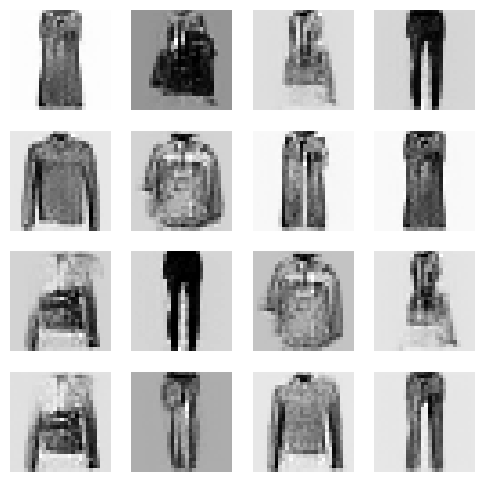

Época 173 de 1000
Pérdida del discriminador: 0.6081783771514893, Pérdida del generador: 2.6261918544769287
Pérdida del discriminador: 0.6207115054130554, Pérdida del generador: 2.565288543701172
Pérdida del discriminador: 0.6435003876686096, Pérdida del generador: 2.4829883575439453
Pérdida del discriminador: 0.7700485587120056, Pérdida del generador: 2.566486358642578
Pérdida del discriminador: 0.6961694955825806, Pérdida del generador: 2.636780261993408
Pérdida del discriminador: 0.7288680076599121, Pérdida del generador: 2.658684253692627
Pérdida del discriminador: 0.7815887928009033, Pérdida del generador: 2.5599048137664795
Pérdida del discriminador: 0.6546081304550171, Pérdida del generador: 2.241206169128418
Pérdida del discriminador: 0.6378332376480103, Pérdida del generador: 2.3134684562683105
Pérdida del discriminador: 0.6786168813705444, Pérdida del generador: 2.511202573776245
Pérdida del discriminador: 0.6905457973480225, Pérdida del generador: 2.5818629264831543
Pérdida d

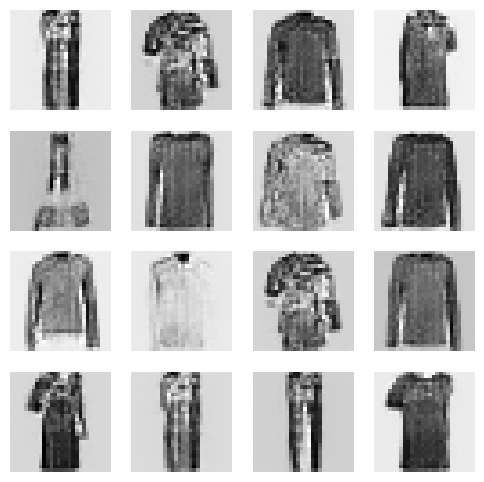

Época 175 de 1000
Pérdida del discriminador: 0.689811110496521, Pérdida del generador: 2.254162311553955
Pérdida del discriminador: 0.7072583436965942, Pérdida del generador: 2.418215274810791
Pérdida del discriminador: 0.8016854524612427, Pérdida del generador: 2.632143497467041
Pérdida del discriminador: 0.6813355088233948, Pérdida del generador: 2.8196702003479004
Pérdida del discriminador: 0.8037766218185425, Pérdida del generador: 2.5335278511047363
Pérdida del discriminador: 0.7039350271224976, Pérdida del generador: 2.4053940773010254
Pérdida del discriminador: 0.690660834312439, Pérdida del generador: 2.418168544769287
Pérdida del discriminador: 0.7643098831176758, Pérdida del generador: 2.420754909515381
Pérdida del discriminador: 0.8823046088218689, Pérdida del generador: 2.4577558040618896
Pérdida del discriminador: 0.8089413642883301, Pérdida del generador: 2.231266736984253
Pérdida del discriminador: 0.7487369179725647, Pérdida del generador: 2.3775641918182373
Pérdida del

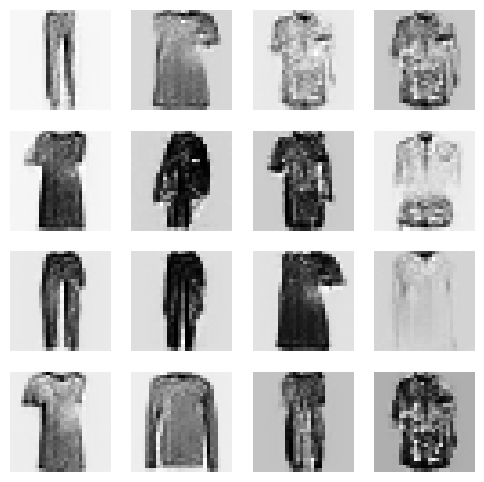

Época 177 de 1000
Pérdida del discriminador: 0.5988104939460754, Pérdida del generador: 2.4028592109680176
Pérdida del discriminador: 0.6169052720069885, Pérdida del generador: 2.507476806640625
Pérdida del discriminador: 0.6464396715164185, Pérdida del generador: 2.7541122436523438
Pérdida del discriminador: 0.6363232731819153, Pérdida del generador: 3.015592575073242
Pérdida del discriminador: 0.6762162446975708, Pérdida del generador: 2.6865897178649902
Pérdida del discriminador: 0.6605129837989807, Pérdida del generador: 2.6334118843078613
Pérdida del discriminador: 0.6523207426071167, Pérdida del generador: 2.530895948410034
Pérdida del discriminador: 0.6716930866241455, Pérdida del generador: 2.5227036476135254
Pérdida del discriminador: 0.6866795420646667, Pérdida del generador: 2.461282968521118
Pérdida del discriminador: 0.7110563516616821, Pérdida del generador: 2.737865447998047
Pérdida del discriminador: 0.786965012550354, Pérdida del generador: 2.609872817993164
Pérdida de

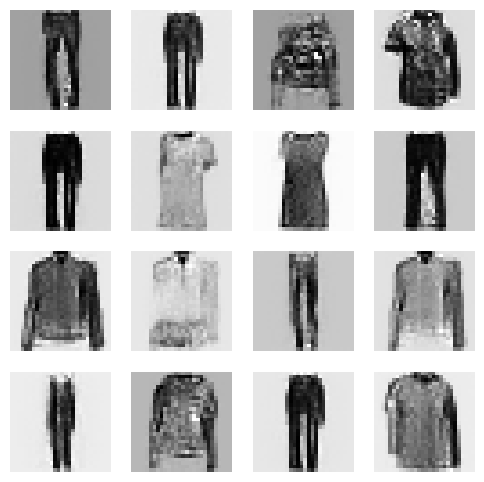

Época 179 de 1000
Pérdida del discriminador: 0.6645461320877075, Pérdida del generador: 2.747396230697632
Pérdida del discriminador: 0.6784815788269043, Pérdida del generador: 2.6535115242004395
Pérdida del discriminador: 0.6782110929489136, Pérdida del generador: 2.4549291133880615
Pérdida del discriminador: 0.7407711744308472, Pérdida del generador: 2.4069411754608154
Pérdida del discriminador: 0.640561044216156, Pérdida del generador: 2.4793381690979004
Pérdida del discriminador: 0.6266717910766602, Pérdida del generador: 2.6569037437438965
Pérdida del discriminador: 0.6831620335578918, Pérdida del generador: 2.7736170291900635
Pérdida del discriminador: 0.6233627200126648, Pérdida del generador: 2.601677894592285
Pérdida del discriminador: 0.7164996266365051, Pérdida del generador: 2.5569889545440674
Pérdida del discriminador: 0.6651678085327148, Pérdida del generador: 2.577383041381836
Pérdida del discriminador: 0.6279597282409668, Pérdida del generador: 2.5492820739746094
Pérdida

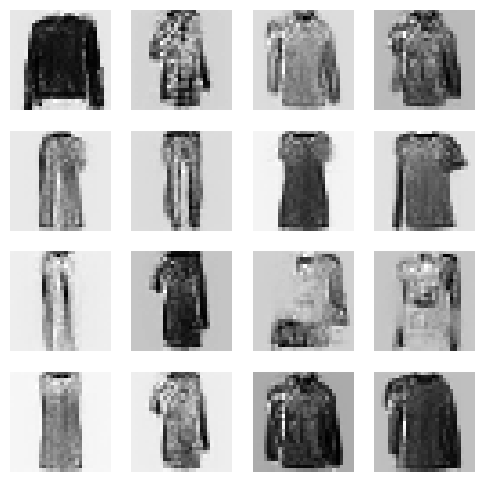

Época 181 de 1000
Pérdida del discriminador: 0.7600724101066589, Pérdida del generador: 2.6490821838378906
Pérdida del discriminador: 0.6252459287643433, Pérdida del generador: 2.568225622177124
Pérdida del discriminador: 0.7084969282150269, Pérdida del generador: 2.4831128120422363
Pérdida del discriminador: 0.7220158576965332, Pérdida del generador: 2.5174825191497803
Pérdida del discriminador: 0.7406139373779297, Pérdida del generador: 2.4448556900024414
Pérdida del discriminador: 0.7460856437683105, Pérdida del generador: 2.3760666847229004
Pérdida del discriminador: 0.720784604549408, Pérdida del generador: 2.4144630432128906
Pérdida del discriminador: 0.6331350207328796, Pérdida del generador: 2.5695786476135254
Pérdida del discriminador: 0.6897313594818115, Pérdida del generador: 2.6750686168670654
Pérdida del discriminador: 0.7288923263549805, Pérdida del generador: 2.740185022354126
Pérdida del discriminador: 0.7105367183685303, Pérdida del generador: 2.6729848384857178
Pérdid

KeyboardInterrupt: 

In [24]:
# Entrenamiento de la GAN
for epoch in range(EPOCHS):
  print(f"Época {epoch+1} de {EPOCHS}")

  for real_images in dataset:
    # Obtiene el tamaño del lote actual
    current_batch_size = real_images.shape[0]

    # Genera ruido aleatorio para crear imágenes falsas
    noise = tf.random.normal([current_batch_size, LATENT_DIM])

    # Crea imágenes falsas con el generador
    generated_images = generator(noise, training=True)

    # Etiquetas reales y falsas
    real_labels = tf.ones((current_batch_size, 1))  # Imágenes reales (etiqueta = 1)
    fake_labels = tf.zeros((current_batch_size, 1))  # Imágenes generadas (etiqueta = 0)

    # Entrena el discriminador
    with tf.GradientTape() as disc_tape:  # Crea un contexto de gradiente para calcular la pérdida del discriminador
      # Obtiene las predicciones del discriminador para las imágenes reales
      real_output = discriminator(real_images, training=True)
      # Obtiene las predicciones del discriminador para las imágenes generadas
      fake_output = discriminator(generated_images, training=True)
      # Calcula la pérdida del discriminador para las imágenes reales
      disc_loss_real = cross_entropy(real_labels, real_output)
      # Calcula la pérdida del discriminador para las imágenes generadas
      disc_loss_fake = cross_entropy(fake_labels, fake_output)
      # Suma ambas pérdidas para obtener la pérdida total del discriminador
      disc_loss = disc_loss_real + disc_loss_fake

    # Calcula los gradientes de la pérdida con respecto a las variables entrenables del discriminador
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Aplica los gradientes para actualizar los pesos del discriminador
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Genera ruido aleatorio para entrenar el generador
    noise = tf.random.normal([current_batch_size, LATENT_DIM])

    # Entrena el generador
    with tf.GradientTape() as gen_tape:  # Crea un contexto de gradiente para calcular la pérdida del generador
      # Crea imágenes falsas con el generador
      generated_images = generator(noise, training=True)
      # Evalúa las imágenes generadas con el discriminador (sin actualizar los pesos)
      fake_output = discriminator(generated_images, training=False)
      # Calcula la pérdida del generador intentando "engañar" al discriminador
      gen_loss = cross_entropy(real_labels, fake_output)

    # Calcula los gradientes de la pérdida con respecto a las variables entrenables del generador
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Aplica los gradientes para actualizar los pesos del generador
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    # Muestra la pérdida de cada red neuronal en cada época
    print(f"Pérdida del discriminador: {disc_loss.numpy()}, Pérdida del generador: {gen_loss.numpy()}")

  # Muestra el progreso cada 2 épocas
  if (epoch+1) % 2 == 0 or epoch == EPOCHS-1:
    # Genera y muestra imágenes de ejemplo
    noise = tf.random.normal([16, LATENT_DIM])
    generated_images = generator(noise, training=False)
    generated_images = (generated_images+1) / 2  # Reescala de [-1, 1], a [0, 1]

    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for img, ax in zip(generated_images, axes.flatten()):
      ax.imshow(img, cmap="binary")
      ax.axis("off")
    plt.show()
  
    # Graba en disco los modelos cada 25 épocas
  if (epoch+1) % 25 == 0:
    # Obtiene la fecha y hora actual
    current_time = datetime.now().strftime("%d-%m-%Y-%H%M")
    
    # Guarda los modelos
    generator.save(f"./models/generador_prendas_{current_time}_{epoch+1}ep_{NUMBER_OF_IMAGES}img.keras")
    discriminator.save(f"./models/discriminador_prendas_{current_time}_{epoch+1}ep_{NUMBER_OF_IMAGES}img.keras")

In [14]:
generator = load_model("./models/generador_prendas_11-02-2025-2358_50+175ep_70000img.keras")

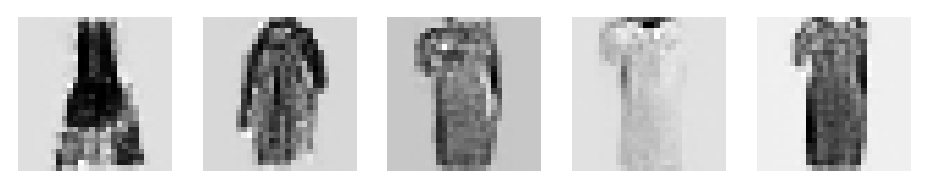

In [ ]:
SAVE_PATH = "./images/"  # Directorio donde se guardarán las imágenes

# Crear la carpeta si no existe
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

# Guarda 5 imágenes generadas
plt.figure(dpi=180)
for i in range(5):
    noise = tf.random.normal([16, 200])
    generated_images = generator(noise, training=False)
    img = (generated_images+1) / 2  # Reescala de [-1, 1], a [0, 1]
    
    plt.subplot(1, 5, i+1)
    plt.imshow(img[0], cmap="binary")
    plt.axis('off')

    # Obtiene la fecha y hora actual
    current_time = datetime.now().strftime("%d-%m-%Y-%H%M")
    
    # Guardar imagen en escala de grises
    filename = f"{SAVE_PATH}image_{i}_{current_time}_50+175ep_{70000}imgs.png"
    plt.imsave(filename, img[0, :, :, 0].numpy(), cmap="gray")  # Extrae el canal y usa cmap="gray"
plt.show()